## Import necessary libraries & download dataset

In [1]:
import nltk
import re
import regex
import os
from functools import reduce

nltk.download('punkt')
os.chdir("/content/")
!git clone https://github.com/nmng108/ComOM.git

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Cloning into 'ComOM'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 96 (delta 1), reused 92 (delta 0), pack-reused 0
Receiving objects: 100% (96/96), 1.50 MiB | 17.66 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [2]:
# !pip install transformers
# !git clone --single-branch --branch fast_tokenizers_BARTpho_PhoBERT_BERTweet https://github.com/datquocnguyen/transformers.git
# !pip install -e "/content/transformers"
# !pip install underthesea

In [3]:
# import underthesea as uts
# from underthesea import word_tokenize, sent_tokenize

In [4]:
# Test libraries's APIs
# Conclusion 1: both the NLP libs (nltk, uts) cannot sent_tokenize correctly in a sentence containing citations.
# uts.word_tokenize("   2.   A noi: \"Samsung Galaxy Y10 Plus co kich thứơc man hinh 2.8mm, kha an tuong vi nho hon dang ke.\", va dung nhu vay.")


In [5]:
# !pip install py_vncorenlp

In [6]:
# import py_vncorenlp
# import os

# # Automatically download VnCoreNLP components from the original repository
# # and save them in some local machine folder
# os.mkdir('/content/vncorenlp')
# py_vncorenlp.download_model(save_dir='/content/vncorenlp')

# # Load the word and sentence segmentation component
# rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir='/content/vncorenlp')

In [7]:
# text = "title: So sánh Galaxy Z Fold 4 và iPhone 13 Pro Max: Flagship nào hấp dẫn hơn?	title : So sánh Galaxy Z Fold 4 và iPhone 13 Pro Max : Flagship nào hấp dẫn hơn ?"
# output = rdrsegmenter.word_segment(text)

# output
# # ['Ông Nguyễn_Khắc_Chúc đang làm_việc tại Đại_học Quốc_gia Hà_Nội .', 'Bà Lan , vợ ông Chúc , cũng làm_việc tại đây .']

### Load the Vietnamese stopword list

In [8]:
abs_path: str = "/content/ComOM/vietnamese-stopwords.txt"

if not os.path.isfile(abs_path):
  print(f"Cannot load set of stopwords as the file \"{abs_path}\" is not found")
  exit(-1)

try:
  with open(abs_path, mode="r") as file:
    global stopwords
    stopwords = file.read().split("\n")
    stopwords = set([w.lower() for w in stopwords])

except Exception as e:
  print(f"Error raised while reading {abs_path}: {str(e)}")

print(f"Loaded {len(stopwords)} stopwords in \"{abs_path}\"")

Loaded 1942 stopwords in "/content/ComOM/vietnamese-stopwords.txt"


# A. Load & parse data

### Sample training dataset

In [9]:
# Used for quick tests without importing/reading files
sample_dataset: str = """
title: So sánh Galaxy Z Fold 4 và iPhone 13 Pro Max: Flagship nào hấp dẫn hơn?	title : So sánh Galaxy Z Fold 4 và iPhone 13 Pro Max : Flagship nào hấp dẫn hơn ?

Galaxy Z Fold 4 so với iPhone 13 Pro Max có thật sự đáng mua hơn?	Galaxy Z Fold 4 so với iPhone 13 Pro Max có thật sự đáng mua hơn ?

Samsung Galaxy Z Fold 4 và iPhone 13 Pro Max đều là hai điện thoại cao cấp nhất hiện nay của hai ông lớn Samsung và Apple.	Samsung Galaxy Z Fold 4 và iPhone 13 Pro Max đều là hai điện thoại cao cấp nhất hiện nay của hai ông lớn Samsung và Apple .

Do đó, ngay khi Samsung Z Fold 4 được trình làng, model này đã được đặt lên bàn cân so sánh với iPhone 13 Pro Max.	Do đó , ngay khi Samsung Z Fold 4 được trình làng , model này đã được đặt lên bàn cân so sánh với iPhone 13 Pro Max .

Thiết kế và kích thước màn hình là những điểm khác biệt dễ nhận thấy nhất trên iPhone 13 Pro Max và Samsung Z Fold 4.	Thiết kế và kích thước màn hình là những điểm khác biệt dễ nhận thấy nhất trên iPhone 13 Pro Max và Samsung Z Fold 4 .
{"subject": ["18&&iPhone", "19&&13", "20&&Pro", "21&&Max"], "object": ["23&&Samsung", "24&&Z", "25&&Fold", "26&&4"], "aspect": ["1&&Thiết", "2&&kế"], "predicate": ["11&&khác", "12&&biệt"], "label": "DIF"}
{"subject": ["18&&iPhone", "19&&13", "20&&Pro", "21&&Max"], "object": ["23&&Samsung", "24&&Z", "25&&Fold", "26&&4"], "aspect": ["4&&kích", "5&&thước", "6&&màn", "7&&hình"], "predicate": ["11&&khác", "12&&biệt"], "label": "DIF"}

alt: Samsung Z Fold 4 mang đến đa nhiệm tốt nhờ màn hình lớn	alt : Samsung Z Fold 4 mang đến đa nhiệm tốt nhờ màn hình lớn

des:	des :

alt: so-sanh-thong-so-cau-hinh-galaxy-z-fold-4-va-iphone-13-pro-max-xtmobile	alt : so-sanh-thong-so-cau-hinh-galaxy-z-fold - 4 - va-iphone - 13 - pro-max-xtmobile

6.  6.

Đó là lý do hãng Samsung cho ra đời phiên bản Galaxy S20 FE, giúp người dùng sở hữu smartphone với chất lượng của siêu phẩm Galaxy S20 nhưng với mức giá rẻ hơn.	Đó là lý do hãng Samsung cho ra đời phiên bản Galaxy S20 FE , giúp người dùng sở hữu smartphone với chất lượng của siêu phẩm Galaxy S20 nhưng với mức giá rẻ hơn .
{"subject": ["12&&Galaxy", "13&&S20", "14&&FE"], "object": ["28&&Galaxy", "29&&S20"], "aspect": ["32&&mức", "33&&giá"], "predicate": ["34&&rẻ", "35&&hơn"], "label": "COM+"}

T
"""

# nltk.word_tokenize(nltk.line_tokenize(sample_dataset)[0])


## I. Load from files

In [10]:
# Make sure that you have pull the git repository (first step)
TRAINING_DATASET_DIR: str = "/content/ComOM/VLSP2023_ComOM_training_v2"
TEST_DATASET_DIR: str = "/content/ComOM/VLSP2023_ComOM_public_test_nolabel/VLSP2023_ComOM_public_test_nolabel"

""" Temporarily should not set separates_lines = False """
def load_dataset(data_directory: str = TRAINING_DATASET_DIR, separates_lines: bool = True) -> list:
  result: list = []

  if not os.path.isdir(data_directory):
    print("Loading dataset has failed. Load sample dataset instead")
    # May use sample dataset instead
    return sample_dataset

  for parent_dir_path, dirnames, filenames in os.walk(data_directory):
    for filename in filenames:
      if not filename.endswith(".txt"): continue

      abs_path: str = os.path.join(parent_dir_path, filename)

      try:
        with open(abs_path, mode = 'r') as file:
          text = file.read()

          if separates_lines: result.extend(text.split("\n"))
          else: result.append(text)

      except Exception as e:
        print(f"Error raised while reading {filename}: {str(e)}")

  return result

load_dataset(separates_lines=False)[0]

'Title: Cùng phân khúc, nên mua iPhone 13 Pro Max hay Xiaomi Mi 11 Ultra?\tTitle : Cùng phân khúc , nên mua iPhone 13 Pro Max hay Xiaomi Mi 11 Ultra ?\n\nTrong bài viết ngày hôm nay, hãy cùng FPTShop so sánh hai chiếc smartphone cao cấp có thể nói là tốt nhất trên thị trường hiện nay là iPhone 13 Pro Max và Galaxy S21 Ultra để xem đâu mới là lựa chọn tốt hơn cho người dùng nhé!\tTrong bài viết ngày hôm nay , hãy cùng FPTShop so sánh hai chiếc smartphone cao cấp có thể nói là tốt nhất trên thị trường hiện nay là iPhone 13 Pro Max và Galaxy S21 Ultra để xem đâu mới là lựa chọn tốt hơn cho người dùng nhé !\n{"subject": ["13&&hai", "14&&chiếc", "15&&smartphone", "16&&cao", "17&&cấp"], "object": [], "aspect": [], "predicate": ["22&&tốt", "23&&nhất", "24&&trên", "25&&thị", "26&&trường", "27&&hiện", "28&&nay"], "label": "SUP+"}\n\nTrong bài viết ngày hôm nay, hãy cùng so sánh 2 chiếc smartphone tốt nhất của Apple và Xiaomi ở thời điểm hiện tại là iPhone 13 Pro Max chính hãng và Xiaomi Mi 11 U

## II. Parse dataset

### 1. **Modeling classes**

In [11]:
class Quintuple():
  """
    Represent a quintuple.
  """

  def __init__(self, *args):
    """
      Should not use this constructor directly.
      You can use either of the 2 static methods below.
    """

    if len(args) == 1 and isinstance(args[0], dict):
      self.subject = args[0].get('subject')
      self.object = args[0].get('object')
      self.aspect = args[0].get('aspect')
      self.predicate = args[0].get('predicate')
      self.label: str = args[0].get('label')

    elif len(args) == 5:
      self.subject = args[0]
      self.object = args[1]
      self.aspect = args[2]
      self.predicate = args[3]
      self.label: str = args[4]

    else: raise ValueError("Constructing Quintuple instance got failed.")

  @staticmethod
  def fromDict(obj: dict):
    return Quintuple(obj)

  @staticmethod
  def fromValues(subject: str | None, _object: str | None, aspect: str | None, predicate: str, label: str):
    return Quintuple(subject, _object, aspect, predicate, label)

  def toDict(self) -> dict:
    return {
      'subject': self.subject,
      'object': self.object,
      'aspect': self.aspect,
      'predicate': self.predicate,
      'label': self.label
    }

class DataPointBase():
  def __init__(self, sentence: str | dict | list):
    assert isinstance(sentence, str | dict | list), (
        "Sentence must be either of [str | dict | list]"
    )

    self.sentence = sentence

  def toDict(self) -> dict:
    return {'sentence': self.sentence}

class DataPoint(DataPointBase):
  """
    Represent a data point, which should be a unique sentence and may contains
    a *single* quintuple (if any).
  """

  def __init__(self, sentence: str | dict | list, quintuple: Quintuple | str):
    super().__init__(sentence)

    assert quintuple is None or isinstance(quintuple, Quintuple | str), (
        "quintuple must be either of [Quintuple | str | None]"
    )

    self.quintuple = quintuple

  # Override
  def toDict(self) -> dict:
    result_dict: dict = super().toDict()

    if not self.quintuple is None:
      result_dict.update(
          {'quintuple': self.quintuple} if isinstance(self.quintuple, str)
          else self.quintuple.toDict()
      )

    return result_dict

class MultiQuintuplesDataPoint(DataPointBase):
  """
    Represent a data point, which should be a unique sentence and may contains
    *multiple* quintuples.

    This should be the result data type of parsing dataset.
  """

  def __init__(self, sentence: str | dict | list, quintuples: list | None):
    super().__init__(sentence)

    assert quintuples is None or (
        isinstance(quintuples, list) and all([isinstance(q, Quintuple | str) for q in quintuples])
    ), (
        "quintuples must be a list of [Quintuple | str] or None"
    )

    self.quintuples = quintuples

  # Override
  def toDict(self) -> dict:
    result_dict: dict = super().toDict()
    quintuples = None if self.quintuples is None else (
        [q.toDict() if isinstance(q, Quintuple) else q for q in self.quintuples]
    )

    result_dict.update({'quintuples': quintuples})

    return result_dict

  def addQuintuple(self, quintuples: Quintuple | str | list):
    if isinstance(quintuples, list):
      self.quintuples.extend(quintuples)
    else:
      self.quintuples.append(quintuples)

  def toSeparateDataPoints(self) -> list[DataPoint]:
    """ Returns a list of DataPoint """
    if not self.quintuples is None and len(self.quintuples) > 0:
      return [DataPoint(self.sentence, q) for q in self.quintuples]

    return [DataPoint(self.sentence, None)]

class Dataset():
  """
    Alternative of DatasetUtils (below); need to be instantiated before use

    This stores a list of MultiQuintuplesDataPoint objects.
  """

  def __init__(self, multi_quin_dataset: list[MultiQuintuplesDataPoint]):
    self.__dataset: list[MultiQuintuplesDataPoint] = multi_quin_dataset

  def get(self) -> list[MultiQuintuplesDataPoint]: return self.__dataset

  def toMultiQuintuplesDictList(self, min_q: int = 0, max_q: int = 10) -> list[dict]:
    """
      Convert MultiQuintuplesDataPoint list to a dict list, where
      each element should be an unique sentence and may contains *multiple* quintuples
      stored in the "quintuples" field.
      - min_q & max_q are used for defining a range of number of quintuples that
      every element must satisfy.
    """

    assert min_q >= 0 and min_q <= max_q, (
        "Min num of quintuples must be smaller or equal to max num, and both must be larger than 0"
    )

    assert isinstance(self.__dataset, list) and all([isinstance(d, MultiQuintuplesDataPoint) for d in self.__dataset]), (
        "Input must be a list of MultiQuintuplesDataPoint instances"
    )

    # Define condition of the filter
    def satisfies_num_of_quintuples(quintuples: list) -> bool:
      if min_q == 0:
        return quintuples is None or (
            isinstance(quintuples, list) and len(quintuples) <= max_q
        )

      return isinstance(quintuples, list) and (
          len(quintuples) >= min_q and len(quintuples) <= max_q
      )

    return list(filter(lambda d: satisfies_num_of_quintuples(d.get('quintuples')), (
      [d.toDict() for d in self.__dataset]
    )))

  def toDictList(self) -> list[dict]:
    """ Convert DataPoint list to dict list """
    data_point_list: list[DataPoint] = self.MultiQuintuplesDataPoints_to_DataPoints(self.__dataset)

    return [d.toDict() for d in data_point_list]

  def convertMultiQuinToSingleQuin(self) -> list[DataPoint]:
    """
      Convert MultiQuintuplesDataPoint list to a DataPoint list, where
      each element is a sentence and may contains at most 1 quintuple
      stored in the "quintuple" field.

      A.k.a flattening dataset
    """

    result_list: list[DataPoint] = []

    for data_point in self.__dataset:
      result_list.extend(data_point.toSeparateDataPoints())

    return result_list

class DatasetUtils():
  """ Alternative of the Dataset class; only includes static methods """

  @staticmethod
  def to_multi_quintuples_dict_list(data_point_list: list[MultiQuintuplesDataPoint],
                                    min_q: int = 0, max_q: int = 10) -> list[dict]:
    """
      Convert MultiQuintuplesDataPoint list to a dict list, where
      each element should be an unique sentence and may contains *multiple* quintuples
      stored in the "quintuples" field.
      - min_q & max_q are used for defining a range of number of quintuples that
      every element must satisfy.
    """

    assert min_q >= 0 and min_q <= max_q, (
        "Min num of quintuples must be smaller or equal to max num, and both must be larger than 0"
    )

    assert isinstance(data_point_list, list) and all([isinstance(d, MultiQuintuplesDataPoint) for d in data_point_list]), (
        "Input must be a list of MultiQuintuplesDataPoint instances"
    )

    # Define condition of the filter
    def satisfies_num_of_quintuples(quintuples: list) -> bool:
      if min_q == 0:
        return quintuples is None or (
            isinstance(quintuples, list) and len(quintuples) <= max_q
        )

      return isinstance(quintuples, list) and (
          len(quintuples) >= min_q and len(quintuples) <= max_q
      )

    return list(filter(lambda d: satisfies_num_of_quintuples(d.get('quintuples')), (
      [d.toDict() for d in data_point_list]
    )))

  @staticmethod
  def toDictList(data_point_list: list[DataPoint]) -> list[dict]:
    """ Convert DataPoint list to a dict list """
    assert all([isinstance(d, DataPoint) for d in data_point_list]), (
        "Input must be a list of DataPoint instances"
    )

    return [d.toDict() for d in data_point_list]

  @staticmethod
  def MultiQuintuplesDataPoints_to_DataPoints(data_point_list: list[MultiQuintuplesDataPoint]) -> list[DataPoint]:
    """
      Convert MultiQuintuplesDataPoint list to a DataPoint list, where
      each element is a sentence and may contains at most 1 quintuple
      stored in the "quintuple" field.

      A.k.a flattening dataset
    """

    result_list: list[DataPoint] = []

    for data_point in data_point_list:
      result_list.extend(data_point.toSeparateDataPoints())

    return result_list


# test
DatasetUtils.toDictList([DataPoint("abc sent", Quintuple.fromValues("fs", "fdsj", None, None, None))])

[{'sentence': 'abc sent',
  'subject': 'fs',
  'object': 'fdsj',
  'aspect': None,
  'predicate': None,
  'label': None}]

### 2. ``parse_data(dataset_array: list): list`` (main function)
- Output:
  ```python
  [{
    "sentence": "...",
    "quintuples": "{...}"
  },]
  # or
  [<MultiQuintuplesDataPoint instance>,]
  ```

In [12]:
from multipledispatch import dispatch

@dispatch(list)
def parse_data(dataset_array: list[str] = []) -> list[MultiQuintuplesDataPoint]:
  assert all([not "\n" in line for line in dataset_array]), (
      "Provided dataset_array's elements must be single lines and do not contains '\n'"
  )

  result_dataset_list: list = [] # the list to be returned

  for i in range(0, len(dataset_array)):
    current_line = dataset_array[i].strip()

    # Stop considering a line if it is empty or a label (which has JSON format)
    if len(current_line) == 0 or re.match(r"\{.*\}", current_line): continue # regex may be more concrete

    sentences = current_line.split("\t")

    if len(sentences) < 1 or len(sentences[0].strip()) == 0: continue

    dest_sentence = sentences[0].strip() if len(sentences) < 2 else sentences[1].strip()
    # dest_sentence = sentences[1].strip() if len(sentences) >= 2 else None # tmp

    """ Create data point """
    data_point = MultiQuintuplesDataPoint(dest_sentence, None)

    # Check if any corresponding label (quintuple) exists in the following lines
    # and append them to a list
    j = i + 1
    quintuples: list = []

    while j < len(dataset_array) and re.match(r'\{.*\}', dataset_array[j]):
      quintuples.append(dataset_array[j])
      # result_dataset_list.append(data_point.copy()) # old

      j += 1

    result_dataset_list.append(data_point)
    data_point.quintuples = quintuples if len(quintuples) > 0 else None
    """"""

    ## TEST: compare tokenizing between 2 sentences ##
    # if len(sentences) > 1:
    #   tokens_s0 = nltk.word_tokenize(sentences[0])
    #   tokens_s1 = nltk.word_tokenize(sentences[1])
    #   # compare the number of token
    #   if len(tokens_s0) != len(tokens_s1) and sentences[0].find("+") >= 0:
    #     print(f"\nSent 0:{tokens_s0}' ({len(tokens_s0)})")
    #     print(f"Sent 1:{tokens_s1}' ({len(tokens_s1)})")
    #     if len(quintuples) > 0:
    #       print(f"{quintuples}\n")
    ####

  return result_dataset_list

@dispatch(str)
def parse_data(dataset: str = "") -> list:
  # split by "\n" to sequentially read each line of the input
  return parse_data(dataset.split("\n"))

# test
# test_list = parse_data(load_dataset(separates_lines=False)[1])
# DatasetUtils.to_multi_quintuples_dict_list(test_list, 3)
# test_list = parse_data(load_dataset(separates_lines=True))

### 3. Sub-functions of `convert_dataset_representation()`

#### a. ``deserialize(obj_string: str)``
Converts JSON to a dict

- Output: ``{'subject': "", 'object': "", 'aspect': "", 'predicate': "", 'label': ""}``

In [13]:
import json

def deserialize(obj_string: str) -> Quintuple:

  if obj_string == None or len(obj_string) == 0:
    return

  try:
    obj = json.loads(obj_string)

    return Quintuple.fromDict(obj)

  except json.JSONDecodeError as e:
    print(f"Error occured while JSON-decoding {obj_string}:\n{e}")
    return

  except ValueError as e:
    print(f"Error occured while JSON-decoding {obj_string}:\n{e}")
    return

### TEST ###
test_list = parse_data(load_dataset(separates_lines=False)[1])

min_q = 2

# Dataset(test_list).toMultiQuintuplesDictList(min_q)
# DatasetUtils.to_multi_quintuples_dict_list(test_list, min_q)

[deserialize(Dataset(test_list).toMultiQuintuplesDictList(min_q)[0].get('quintuples')[i]).toDict() for i in range(min_q)]
# [deserialize(DatasetUtils.to_multi_quintuples_dict_list(test_list, min_q)[0].get('quintuples')[i]).toDict() for i in range(min_q)]

[{'subject': ['1&&Samsung'],
  'object': [],
  'aspect': ['3&&góc', '4&&chụp'],
  'predicate': ['5&&rộng', '6&&hơn'],
  'label': 'COM+'},
 {'subject': ['17&&cả', '18&&2', '19&&máy'],
  'object': ['17&&cả', '18&&2', '19&&máy'],
  'aspect': ['13&&chất', '14&&lượng', '15&&hình'],
  'predicate': ['20&&đều', '21&&rất', '22&&tương', '23&&xứng'],
  'label': 'EQL'}]

#### b. ``parse_indexed_word_list(quintuple_field: list): dict``

Converts original list of words of each quintuple field into the new form as follow:
  - Input: ``["12&&Galaxy", "13&&S20", "14&&FE"]``
  - Output: 1 of 3 formats below; by default: ``[str] "Galaxy S20 FE"``

Used by ``parse_quintuple_word_lists(quintuple_field)`` (below)

##### sub-function

In [14]:
class IndexedWord():
  def __init__(self, index, word):
    self.index = index
    self.word = word

  def toDict(self):
    return {self.index: self.word}


def parse_indexed_word(indexed_word: str) -> IndexedWord | None:
  """
    (sub-function)
    Input: <index>&&<word>
    Output: [dict] {<index>: <word>} or None if the input is malformed or None
  """
  if not (isinstance(indexed_word, str) and re.match("^\d*&&.*$", indexed_word)):
    print(f"The word '{indexed_word}' is None or malformed.")
    return

  try:
    parts: list = indexed_word.split("&&")

    if len(parts) != 2: raise ValueError("invalid")

    # return {int(parts[0]): parts[1]}
    return IndexedWord(int(parts[0]), parts[1])

  # Mostly not happen
  except ValueError as err:
    print(f"'{parts[0]}' (in '{indexed_word}') is malformed.")
    return

##### Format 1: `[str] "Galaxy S20 FE"` (default)

In [15]:
"""
    Main function (in this section).
    - Input: a list of indexed word; an input indexed word should have the
            original format: "<index>&&'<word>'", thus there should be 2 parts after being split.
    - Output: [str] "..."
"""
def parse_indexed_word_list(quintuple_field: list):
  if not isinstance(quintuple_field, list): return # if None

  result_word_list: list = list()

  for word in quintuple_field:
    if not (isinstance(word, str) and re.match("^\d*&&.*$", word)):
      print(f"The word '{word}' is None or malformed.")
      continue

    parsed_element = parse_indexed_word(word)
    # may be None
    if parsed_element == None: pass

    result_word_list.append(parsed_element.word) # get word only

  return " ".join(result_word_list)

parse_indexed_word_list(["3&&sdf", "5&&wjfal"])

'sdf wjfal'

##### Format 2: `[dict] {12: "Galaxy", 13: "S20", 14: "FE"}`

In [16]:
# """
#     Main function (in this section).
#     - Input: a list of indexed word; an input indexed word should have the
#             original format: "<index>&&'<word>'", thus there should be 2 parts after being split.
#     - Output: [dict] {<index>: "<word>", ...}
# """
# def parse_indexed_word_list(quintuple_field: list):
#   if not isinstance(quintuple_field, list): return # if None

#   result_word_list = dict()

#   for word in quintuple_field:
#     if not (isinstance(word, str) and re.match("^\d*&&.*$", word)):
#       print(f"The word '{word}' is None or malformed.")
#       continue

#     parsed_element = parse_indexed_word(word)
#     # may be None
#     if parsed_element == None: pass

#     result_word_list.update(parsed_element.toDict())

#   return result_word_list

##### Format 3: `[list] [{12: "Galaxy"}, {13: "S20"},]`

In [17]:
# """
#     Main function (in this section).
#     - Input: a list of indexed word; an input indexed word should have the
#             original format: "<index>&&'<word>'", thus there should be 2 parts after being split.
#     - Output: [list] [{<index>: "<word>"}, ...]
# """
# def parse_indexed_word_list(quintuple_field: list):
#   if not isinstance(quintuple_field, list): return # if None

#   result_word_list = list()

#   for word in quintuple_field:
#     if not (isinstance(word, str) and re.match("^\d*&&.*$", word)):
#       print(f"The word '{word}' is None or malformed.")
#       continue

#     parsed_element = parse_indexed_word(word)
#     # may be None
#     if parsed_element == None: pass

#     result_word_list.append(parsed_element.toDict())

#   return result_word_list

#### c. ``parse_quintuple_word_lists(quintuple: dict, stringified: bool = False) -> dict``
- Output: new quintuple with parsed word lists.

Dependency: ``parse_indexed_word_list(quintuple_field: list): dict``

In [18]:
"""
    Parse provided word lists in a quintuple (consist of subject, object, aspect & predicate)
    and convert each list to a dict of indexed .
    - Original element: "<index>&&<word>"
    - New element: {<index>: "<word>"}
"""
def parse_quintuple_word_lists(quintuple: dict | Quintuple, stringified: bool = False) -> Quintuple:
  if not isinstance(quintuple, dict | Quintuple):
    print("Input quintuple must be of type 'dict' or 'Quintuple'.")
    return

  result_quintuple: dict = quintuple.copy() if isinstance(quintuple, dict) else quintuple.toDict()

  # subject
  subject = parse_indexed_word_list(result_quintuple['subject'])
  if stringified: subject = str(subject)

  # object
  obj = parse_indexed_word_list(result_quintuple['object'])
  if stringified: obj = str(obj)

  # aspect
  aspect = parse_indexed_word_list(result_quintuple['aspect'])
  if stringified: aspect = str(aspect)

  # predicate
  predicate = parse_indexed_word_list(result_quintuple['predicate'])
  if stringified: predicate = str(predicate)


  # assign all of them
  result_quintuple['subject'] = subject
  result_quintuple['object'] = obj
  result_quintuple['aspect'] = aspect
  result_quintuple['predicate'] = predicate

  return Quintuple.fromDict(result_quintuple)

#### d. ``sequence_to_word_list(sentence: str, stringified: bool = False) -> dict | str``

Convert a sequence/sentence into a ``dict`` containing indexed tokens,
where each element has either of the formats below.

Dependency: ``nltk.word_tokenize()``

##### Format 1: `[str] "..."` - keep the input unchanged and return it (default)

In [19]:
"""
    Convert a sentence into a list of words.
    Input: a string, which should be a sentence.
    Output: [str] "..."
    Dependency: nltk.word_tokenize()
"""
def sequence_to_word_list(sentence: str, stringified: bool = False):
  return sentence

##### Format 2: `[dict] {<index>: "<word>", ...}`

In [20]:
# """
#     Convert a sentence into a list of words.
#     Input: a string, which should be a sentence.
#     Output: [dict] {<index>: "<word>", ...}
#     Dependency: nltk.word_tokenize()
# """
# def sequence_to_word_list(sentence: str, stringified: bool = False):
#   sentence_words: list = nltk.word_tokenize(sentence)
#   result = dict()

#   for j in range(0, len(sentence_words)): result.update({(j + 1): sentence_words[j]})

#   return str(result) if stringified else result

##### Format 3:`[list] [{<index>: "<word>"}, ...]`

In [21]:
# """
#     Convert a sentence into a list of words.
#     Input: a string, which should be a sentence.
#     Output: [list] [{<index>: "<word>"}, ...]
#     Dependency: underthesea.word_tokenize()
# """
# def sequence_to_word_list(sentence: str, stringified: bool = False):
#   sentence_words: list = uts.word_tokenize(sentence)
#   result = list()

#   for j in range(0, len(sentence_words)): result.append({(j + 1): sentence_words[j]})

#   return str(result) if stringified else result

### 4. `convert_dataset_representation(dataset_array: list[MultiQuintuplesDataPoint], stringified: bool = False) -> list`
Convert dataset representation, which consist of deserializing JSON (quintuple) & formating word lists.
  - **Input**:
    - dataset_list: a list of MultiQuintuplesDataPoint objects that has the following format:
    ```python
      {
        'sentence': "Galaxy S20...",
        'quintuples': ['{\"subject\": [\"1&&Galaxy\", \"2&&S20\"],...}',]
      }
    ```

    - **stringified**: boolean param, which determines whether all the *non-hashable* values (list, dict...) are converted to string or not.

  - **Output**: a list of MultiQuintuplesDataPoint objects that have the following format:
    ```python
      {
        'sentence': {1: "Galaxy", 2: "S20", ...}, # or simply original string
        'quintuples': [{
          'subject': {1: "Galaxy", 2: "S20"},
          'object': {1: "Galaxy", 2: "S21"},
          'aspect': {1: "Thiết", 2: "kế"},
          'predicate': {1: "đẹp", 2: "hơn"},
          'label': "COM+"
        },]
      },
    ```

Dependencies:
- `deserialize(obj_string)`
- `parse_quintuple_word_lists(quintuple)`
- `sequence_to_word_list(sequence)`

In [22]:
""" Main function in this section """
def convert_dataset_representation(dataset_list: list[MultiQuintuplesDataPoint], stringified: bool = False):
  """
    Note that this function will modify data directly on input (dataset_list), thus
    there'is no output
    (param) dataset_list: list of MultiQuintuplesDataPoint
  """
  # result_dataset_list: list = DatasetUtils.to_multi_quintuples_dict_list(dataset_list)

  for data_point in dataset_list:
    # Assign refs to local variable
    quintuples: list = data_point.quintuples

    # Convert sentences into lists of words
    data_point.sentence = sequence_to_word_list(data_point.sentence, stringified)

    if quintuples == None or len(quintuples) == 0: continue

    # Convert JSON to Quintuple object
    data_point.quintuples = [deserialize(q) for q in quintuples]

    # Parse word lists
    data_point.quintuples = [parse_quintuple_word_lists(q, stringified) for q in data_point.quintuples]

    # Update data point with new columns from deserialized quintuple

    # data_point.update(quintuple_object)
    # data_point.pop("quintuple")

  # return result_dataset_list

## III. Load results into variables

In [23]:
training_dataset = parse_data(load_dataset(TRAINING_DATASET_DIR))
test_dataset = parse_data(load_dataset(TEST_DATASET_DIR))

# Any change will impact directly on input object
convert_dataset_representation(training_dataset)
convert_dataset_representation(test_dataset)

# test
len(DatasetUtils.to_multi_quintuples_dict_list(training_dataset))

4171

In [24]:
# test

# training_dataset[0:20]
# DatasetUtils.to_multi_quintuples_dict_list(training_dataset)
# DatasetUtils.MultiQuintuplesDataPoints_to_DataPoints(training_dataset)
# DatasetUtils.toDictList(training_dataset[20:39])

# B. Data analysis

**Caution**: The regex `".*"` should not be used to filter non-empty strings in either of `pandas.DataFrame.contains` and `pandas.DataFrame.match`.
Using `".*"` with one of these methods may output the same as input.

Instead, we can use `"^.{1,}$"` or similar regexes. (there may be a problem with intepreting "+")

## Preparations

In [25]:
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Initialize DataFrame ##
train_df = pd.DataFrame(DatasetUtils.to_multi_quintuples_dict_list(training_dataset))
test_df = pd.DataFrame(DatasetUtils.to_multi_quintuples_dict_list(test_dataset))
####

## Flatten training dataset ##
# Constant; should only use this to create DataFrame or replicate this if needed
flattened_train_dataset = DatasetUtils.toDictList(
    DatasetUtils.MultiQuintuplesDataPoints_to_DataPoints(training_dataset)
)
flattened_train_df = pd.DataFrame(flattened_train_dataset)
####

## Constants ##
TOTAL_TRAIN_SENTENCES: int = len(training_dataset)
TOTAL_TEST_SENTENCES: int = len(test_dataset)

# Training dataset properties
TOTAL_TRAIN_SENTENCES_WITHOUT_QUINTUPLE: int = len([d for d in training_dataset if d.quintuples is None or len(d.quintuples) == 0])
TOTAL_TRAIN_SENTENCES_CONTAIN_QUINTUPLE: int = TOTAL_TRAIN_SENTENCES - TOTAL_TRAIN_SENTENCES_WITHOUT_QUINTUPLE

TOTAL_QUINTUPLES = len(flattened_train_df[flattened_train_df.label.str.contains("^.{1,}$", na=False)])
####

planning:
Showing necessary statistical info & diagrams taken from data (both training & test)
- Number of quintuples of a sentence? Number of sentences that have & don't have quintuple?
- word cloud & frequency of word's existence (in predicate, aspect...?)

- check if any predicate & label are absent in all quintuples (just for confirmation)


In [26]:
print(f"""1. Total number of sentences:
  - Training dataset: {TOTAL_TRAIN_SENTENCES}
  - Test dataset: {TOTAL_TEST_SENTENCES}"""
)

1. Total number of sentences:
  - Training dataset: 4171
  - Test dataset: 1732


In [27]:
# Training dataset info
print(f"  - Number of sentences containing quintuple: {TOTAL_TRAIN_SENTENCES_CONTAIN_QUINTUPLE}")
print("After flattening training dataset based on quintuple list:")
print(f"  - Total number of data points: {len(flattened_train_df)}")
print(f"  - Total number of quintuples (or number of data points containing quintuple): {TOTAL_QUINTUPLES}")

  - Number of sentences containing quintuple: 812
After flattening training dataset based on quintuple list:
  - Total number of data points: 4448
  - Total number of quintuples (or number of data points containing quintuple): 1089


### Helper functions

In [28]:
def make_BoW(str_list: list[str], desc=True):
  """ Create a Bag of Word """
  bow: dict = {}

  for subject in str_list:
    tokens = nltk.word_tokenize(subject)

    for t in tokens:
      t = t.lower()
      if bow.get(t) is None: bow.update({t: 1})
      else: bow.update({t: bow.get(t) + 1})

  return dict(sorted(bow.items(), key=lambda w: w[1], reverse=desc))

In [29]:
def render_wordcloud(values: str | list[str], stopwords: list = None,
                     width: int = 500, height: int = 500,
                     max_font_size: int = 50, min_font_size: int = 5,
                     max_words: int = 350, background_color = "white"):
  is_str_list: bool = isinstance(values, list) and all([isinstance(v, str) for v in values])

  assert is_str_list or isinstance(values, str), (
      "values must be a string or a list of strings"
  )

  text: str = " ".join([s for s in values]) if is_str_list else values
  wordcloud = WordCloud(stopwords=stopwords,
                        width=width, height=height, # image resolution
                        min_font_size=min_font_size, max_font_size=max_font_size,
                        max_words=max_words, background_color=background_color
                        ).generate(text)

  plt.figure(figsize=[8,8]) # scale the image
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

## I. Analysis on training dataset

### 1. Counting sentences on number of quintuples

Main function: `sentences_and_quintuples(training_dataset: list[MultiQuintuplesDataPoint])`

In [ ]:
"""
Input:  training_dataset,
        TOTAL_TRAIN_SENTENCES_WITHOUT_QUINTUPLE,
        TOTAL_TRAIN_SENTENCES_CONTAIN_QUINTUPLE
"""
# Training dataset properties
# TOTAL_TRAIN_SENTENCES_WITHOUT_QUINTUPLE: int = len(list(filter(lambda d: d.quintuples is None or len(d.quintuples) == 0, training_dataset)))
# TOTAL_TRAIN_SENTENCES_CONTAIN_QUINTUPLE: int = TOTAL_TRAIN_SENTENCES - TOTAL_TRAIN_SENTENCES_WITHOUT_QUINTUPLE

def sentences_and_quintuples(training_dataset: list[MultiQuintuplesDataPoint]):
  assert all([isinstance(d, MultiQuintuplesDataPoint) for d in training_dataset]), (
      "'training_dataset' must be a list of MultiQuintuplesDataPoint objects."
  )

  # a frequenly-updated variable; used to count number of sentences on each number of quintuples
  num_of_sentences = TOTAL_TRAIN_SENTENCES_WITHOUT_QUINTUPLE

  labels: list[str] = ["0 quintuple"]
  sentences_on_quin: list[int] = [num_of_sentences]
  statistic:str = f"""Total of sentences possessing...
  - 0 quintuple: {num_of_sentences}
  - From 1 quintuple: {TOTAL_TRAIN_SENTENCES_CONTAIN_QUINTUPLE}. For details:\n"""

  def plural_of_quintuple(): return "quintuple" if i == 1 else "quintuples"

  for i in range(1, 6):
    label = str(i) + " " + plural_of_quintuple()
    num_of_sentences = len(list(filter(lambda d: isinstance(d.quintuples, list) and len(d.quintuples) == i, training_dataset)))

    labels.append(label)
    sentences_on_quin.append(num_of_sentences)
    statistic += f"    + {label}: {num_of_sentences}\n"

  labels = labels[:4]
  labels.append(">= 4 quintuples")
  plotted_sentences_on_quin = sentences_on_quin[:4]
  plotted_sentences_on_quin.append(len(training_dataset) - reduce(lambda acc, x: acc + x, plotted_sentences_on_quin))
  statistic += f"    + >= 6 quintuples: {len(training_dataset) - reduce(lambda ac, x: ac + x, sentences_on_quin)}\n"

  dataset: list[dict] = DatasetUtils.to_multi_quintuples_dict_list(training_dataset)

  # Count total of quintuples for each sentence and append to them
  for d in dataset:
    q = d.get('quintuples')
    d.update({'num_of_quin': len(q) if isinstance(q, list) else 0})

  # print(dataset[25]) # test

  df = pd.DataFrame(dataset)

  print(statistic)
  print("""=> Imbalance between number of datapoints with no quintuple and others
  """)

  explodes = [0.05, 0.04, 0.05, 0.06, 0.08]
  color_palette = sbn.color_palette('Set1')

  plt.pie(plotted_sentences_on_quin, labels=labels,
          colors=color_palette, autopct='%.1f%%', explode=explodes,
          radius=1.3, pctdistance=0.75, labeldistance=1.2)
  # plt.legend(labels, loc="upper right")
  # plt.axis('equal')
  # plt.tight_layout()
  # plt.title('Số lượng câu trên số lượng quintuple')
  hole = plt.Circle((0, 0), 0.65, facecolor='white')

  # Current Figure ( plt.gcf() )
  # --> Current Axis ( gca() )
  # --> add the hole
  plt.gcf().gca().add_artist(hole)

  plt.show()
  print()

  plot = sbn.countplot(df, x='num_of_quin',
                      order=df["num_of_quin"].value_counts(ascending=False).index,
                      palette=color_palette)
  plot.set(xlabel="Number of quintuples", ylabel="Number of sentences")
  plot.bar_label(plot.containers[0])

  plt.show()

sentences_and_quintuples(training_dataset)

### 2. Analyzing sentences

Conclusions:
- Most of the sentences start with a capitalized word and end with a '.' (>2600).
- Some are not complete sentence, which may start with not-capitalized word and may not contain subject. e.g.
- Some are combined from 2 sentences. e.g. "".
- Removing characters
  - Special-character candidates: ". . .", " . " (sent separator; rm if num of sent isn't concerned),
  -

In the section 1, we can see an unexpected imbalance between number of sentences not having any quins vs sentences having quins,
where number of zero-quin sentences (3359) is about *4 times* larger than number of sentences with quin (812).

Thus, in this section, we will dive into the sentences to find out *hidden characteristics* of them, by which we may have some bases for making *data cleaning* decisions.

Result: 2810 zero-quin sentences left (540 deleted).

In [30]:
# Original set (before modified)
train_df = pd.DataFrame(DatasetUtils.to_multi_quintuples_dict_list(training_dataset))
len(train_df)

4171

#### General stats (before modified)

##### Distribution of sentence size

Sentence size is calculated by number of tokens.

Conclusion:
- Critically imbalance between quin-owning and non-quin, especially in the range of 1-9 tokens.
- An abnormally large number of sentences have 1-8 tokens.

⇒ The need for identifying reasons & solutions, which aims to <u>make the uneven data more balance</u>.

- Sentence size may be affected by a non-trivial number of non-alphanumeric characters (bracket, comma, quote, etc) (infered from observing both histogram & dataset)
- Sentences's size is mainly in range 10-35, means=18.3, median=17

Sentence with largest number of tokens:
{'sentence': '“ Apple đã tập trung vào việc nâng cao đáng kể Chất lượng hình ảnh tuyệt đối và Độ chính xác màu sắc tuyệt đối của màn hình OLED bằng cách thực hiện hiệu chỉnh màn hình chính xác tại nhà máy , nâng hiệu suất hiển thị tổng thể của iPhone 12 Pro Max lên đến mức độ vượt trội , độ chính xác hoàn hảo đến mức không thể phân biệt bằng mắt thường ” , DisplayMate đánh giá .', 'num_of_tokens': 82}
Sentence with smallest number of tokens:
{'sentence': 'Camera', 'num_of_tokens': 1}

(Test query) 336
       num_of_tokens
count    4171.000000
mean       18.307360
std        12.690769
min         1.000000
25%         9.000000
50%        17.000000
75%        26.000000
max        82.000000


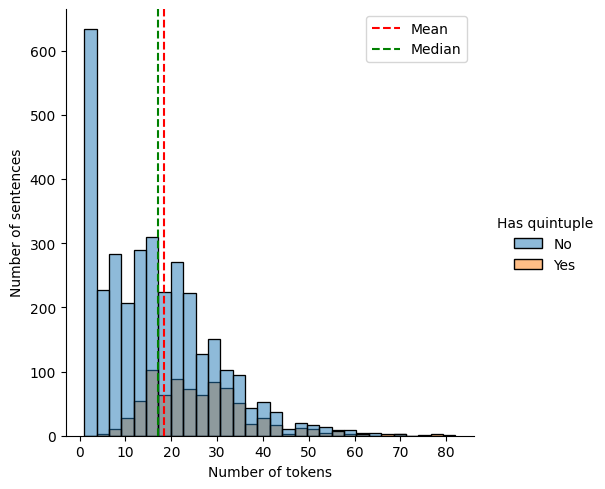

In [31]:
## Size of sentences

sents: list[dict] = [{
    "sentence": sentence,
    "num_of_tokens": len(nltk.word_tokenize(sentence))
} for sentence in train_df.sentence.tolist()]

largest_sent = reduce(lambda max, s: s if max.get("num_of_tokens") < s.get("num_of_tokens") else max, sents)
smallest_sent = reduce(lambda min, s: s if min.get("num_of_tokens") > s.get("num_of_tokens") else min, sents)

print("Sentence with largest number of tokens:")
print(largest_sent) # 82; “ Apple đã tập trung vào việc nâng cao đáng kể Chất lượng hình ảnh tuyệt đối và Độ chính xác màu sắc tuyệt đối của màn hình OLED bằng cách thực hiện hiệu chỉnh màn hình chính xác tại nhà máy , nâng hiệu suất hiển thị tổng thể của iPhone 12 Pro Max lên đến mức độ vượt trội , độ chính xác hoàn hảo đến mức không thể phân biệt bằng mắt thường ” , DisplayMate đánh giá .
print("Sentence with smallest number of tokens:")
print(smallest_sent) # Pin
print()

df = train_df.copy()
df["num_of_tokens"] = [s.get("num_of_tokens") for s in sents]
df["Has quintuple"] = ["Yes" if q is not None else "No" for q in df.quintuples]

print(f"(Test query) {len(df.query('num_of_tokens >= 8 & num_of_tokens <= 10'))}")
print(df.describe())

sbn.displot(data=df, x="num_of_tokens", bins=30, kind="hist", hue="Has quintuple")
# plt.legend(title="Have at least 1 quintuple", labels=["True", "False"])
plt.xlabel("Number of tokens")
plt.ylabel("Number of sentences")
plt.axvline(x=np.mean(df.num_of_tokens), color='red', linestyle='--', label='Mean')
plt.axvline(x=np.median(df.num_of_tokens), color='green', linestyle='--', label='Median')
plt.legend()

plt.show()

#### a. "Sentences" start with numbers
Conclusion: Most of "sentences" start with numbers (section number, quantity) contain only section numbers or along with titles. They don't contain any quintuple.

⇒ Remove all.

In [32]:
# train_df = pd.DataFrame(DatasetUtils.to_multi_quintuples_dict_list(training_dataset))

print(f"Original size of training set: {len(train_df)}")

# Remove "sentences" start with numbers (\d*[(\\.[\d]*)]+)
train_df.drop(train_df[train_df.sentence.str.contains("^\d*[(\\.\d*)]+\W{1,}")].index.tolist(), inplace=True) # 105

print(f"Size of training set after modified: {len(train_df)}")

Original size of training set: 4171
Size of training set after modified: 4066


#### b. Check if any sentence is duplicated

**Conclusion 1**: All duplicate sentences need to be removed.

Suggested command: ``train_df.loc[train_df.sentence.drop_duplicates().index.tolist()]``

(should do this after all other steps)

In [33]:
""" Check if any sentence is duplicated """

# train_df = pd.DataFrame(DatasetUtils.to_multi_quintuples_dict_list(training_dataset))
print(f"Size of the training set before modified: {len(train_df)}")

dups = train_df[train_df.sentence.duplicated()]
print(f"Number of duplicates: {len(dups)}")

dups_with_quin = dups[dups.quintuples.notna()]
print(f"Duplicates where at least 1 quintuple exists: {len(dups_with_quin)} sentences in total.")

# for i in range(len(dups_with_quin)):
#   print(f"Tuple {i + 1}:")
#   print(train_df[train_df.sentence.str.contains(dups_with_quin.iloc[i].sentence)])

train_df = train_df.loc[train_df.sentence.drop_duplicates().index.tolist()] # remove duplicates
print(f"Size of training set after modified: {len(train_df)}")

Size of the training set before modified: 4066
Number of duplicates: 592
Duplicates where at least 1 quintuple exists: 4 sentences in total.
Size of training set after modified: 3474


#### c. Special sentences
- Stats: (original/unique/quin_owner)
  - title: 44/44/0
  - des: 499/216/24(23 unique)
  - alt: 500/332/1

  (always at the first position of the sentences)

  - questions: 126/.../0. All sents containing "?" are questions.

- **Conclusion 2**: the sequences '(alt ?: )|(des ?: )|(title ?: )|(src ?: )' does not contribute any meaning to a sentence, thus should be filtered out before processing.

- **Conclusion 3**:  
  - In questions and titles, there's no sentence that has at least 1 quintuple.
  - In "alt" sentences, there's only 1 sent that has quintuple (2).
  - Sentences ending with '!' mostly don't have quin (except 1).

  => Propose deleting:
    - All '?' & 'title' sentences: 170
    - 'alt' & 'des' sentences: only blank-sentence values (due to the existences of some ambiguous sentences)

- **Conclusion 5**: after removing 'des : ', 'alt : ', the result sentences may have been existed in the original training dataset.
=> Continue removing duplicates by the recommended command above.

In [34]:
# train_df[train_df.sentence.str.contains(r"alt")]#.query("quintuples.notna()")

In [35]:
"""
In this section (and maybe others), I define a "special sentence"
is a sentence containing "alt", "des", "title" or "?", "src" (from test set).
Purpose: Examine if a sentence containing "(alt : )|(des : )|(title : )|(\?)" can have quintuple or not.
Note that all duplicate sentences may have been filtered out (or not) before examining.
"""

# train_df = pd.DataFrame(DatasetUtils.to_multi_quintuples_dict_list(training_dataset))

questions_and_titles = train_df[train_df.sentence.str.contains("(\?)|([Tt][Ii][Tt][Ll][Ee])|([Ss][Rr][Cc])")]
special_sentences = train_df[train_df.sentence.str.contains("([Aa][Ll][Tt])|([Dd][Ee][Ss])")]
print()

## Questions & titles
# print(len(train_df[train_df.sentence.str.contains("title")]))
# print(len(train_df[train_df.sentence.str.contains("\?")]))
print(f"Sentences containing '?' and/or 'title : ' ({len(questions_and_titles)}) and having quintuple:", end=" ")
print(len(questions_and_titles[questions_and_titles.quintuples.notnull()]))
# print(special_sentences[special_sentences.sentence.str.contains("(title)", regex=True)])
print("=> Conclusion 3: The sentences containing '?' and/or 'title : ' should be removed.\n")

# Remove questions and titles
train_df.drop(questions_and_titles.index.tolist(), inplace=True)

## Special sentences
print(f"Number of special sentences starting with 'des : ', 'alt : ': {len(special_sentences)}")  # before removing: 1043; after: 592
# print(f"where number of dups: {len(special_sentences[special_sentences.sentence.duplicated()])}") # before removing: 451; after: 0

## Special sentences with quintuple
special_sentences_with_quin = special_sentences[special_sentences.quintuples.notna()]
print(f"Number of special sentences (starting with 'des : ', 'alt : ') having at least 1 quin: {len(special_sentences_with_quin)}")
print("=> Conclusion 4: Those sentences need to be kept.\n")

print(f"Dups before removing 'des : ' & 'alt : ': {len(train_df[train_df.sentence.duplicated()])}")

# Substitute "(des : ?)|(alt : ?)" with "" and replace old strings with those in train_df
for i in range(len(special_sentences)):
  new_sent = re.sub("(des ?:? ?)|(alt ?:? ?)", "", special_sentences.iloc[i].sentence)
  train_df.sentence.replace(special_sentences.iloc[i].sentence, new_sent, inplace=True)

  # if len(train_df[train_df.sentence == new_sent]) > 0:
  #   print(f"Tuple {i}:")
  #   print(f"Original:\n{special_sentences.iloc[i]}")
  #   print(f"Dup:\n{train_df[train_df.sentence == new_sent]}\n")

tmp = len(train_df[train_df.sentence.duplicated()])

print(f"Dups after removing 'des : ' & 'alt : ': {tmp}")
print(f"""
Conclusion 5: after removing 'des : ', 'alt : ', the result sentences may have
been existed in the original training dataset ({tmp - len(train_df[train_df.sentence.duplicated()])} increased)"""
)

new_dups = train_df[train_df.sentence.duplicated()]
# for i in range(len(new_dups)):
#   print(f"Tuple {i}:")
#   print(train_df[train_df.sentence == new_dups.iloc[i].sentence], end="\n")

# uncomment the code above to print all tuples
print("""
After observing all the duplicates, we can conclude that in each duplicate tuple,
all members are completely the same.
So, we can delete them by reusing the recommended command (conclusion 1)."""
)

train_df = train_df.loc[train_df.sentence.drop_duplicates().index.tolist()] #

# print(f"\nDups after being removed for the 2nd time: {len(train_df[train_df.sentence.duplicated()])} (test)")
print(f"\nSize of training set after modified: {len(train_df)}")


Sentences containing '?' and/or 'title : ' (140) and having quintuple: 1
=> Conclusion 3: The sentences containing '?' and/or 'title : ' should be removed.

Number of special sentences starting with 'des : ', 'alt : ': 548
Number of special sentences (starting with 'des : ', 'alt : ') having at least 1 quin: 24
=> Conclusion 4: Those sentences need to be kept.

Dups before removing 'des : ' & 'alt : ': 0


<ipython-input-35-1d19b3d35ce7>:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  questions_and_titles = train_df[train_df.sentence.str.contains("(\?)|([Tt][Ii][Tt][Ll][Ee])|([Ss][Rr][Cc])")]
<ipython-input-35-1d19b3d35ce7>:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  special_sentences = train_df[train_df.sentence.str.contains("([Aa][Ll][Tt])|([Dd][Ee][Ss])")]


Dups after removing 'des : ' & 'alt : ': 166

Conclusion 5: after removing 'des : ', 'alt : ', the result sentences may have
been existed in the original training dataset (0 increased)

After observing all the duplicates, we can conclude that in each duplicate tuple,
all members are completely the same.
So, we can delete them by reusing the recommended command (conclusion 1).

Size of training set after modified: 3168


#### d. Examine sizes of the training sentences

Note that you should run the previous block to remove redundant sentences/sequences.

**Conclusion 6**: Most of "short" sentences does not contain quintuple. Specifically, we can remove all sentences with 0-3 tokens and consider to remove sentences with 4-7 tokens (but the sentences with quintuple should be kept).


- Sentences with ...
(Pattern: `<total of sentences> - <sentences contain quintuple>`)
  - 0-3 tokens: 163 - 0
  - 4 tokens: 54 - 1
  - 5 tokens: 51 - 2
  - 6 tokens: 55 - 3
  - 7 tokens: 78 - 3
  - 8 tokens: 74 - 7

    ...

In [36]:
""" Examine sizes of the training sentences """
MINIMUM_NUM_OF_TOKENS = 7
# train_df = pd.DataFrame(DatasetUtils.to_multi_quintuples_dict_list(training_dataset))
print(f"Size of training set before modified: {len(train_df)}\n")

for min_t in range(MINIMUM_NUM_OF_TOKENS + 1):

  short_sentences = train_df.loc[[item[0] for item in train_df.sentence.items() if len(nltk.word_tokenize(item[1])) <= min_t]]
  short_sentence_indexes_with_quin = [i for i, row in short_sentences.iterrows() if not row.quintuples is None]

  print(f"Given minimum number of tokens is {min_t}.")
  print(f"Number of short sentences: {len(short_sentences)}")
  print(f"Number of short sentences with quin: {len(short_sentence_indexes_with_quin)}")
  print(f"=> Delete: {len(short_sentences) - len(short_sentence_indexes_with_quin)}")

  ## demo the process of removing short sentences
  short_sentences.drop(short_sentence_indexes_with_quin, inplace=True)
  # print(f"Number of short sentences (after modified): {len(short_sentences)}") # validate
  train_df.drop(short_sentences.index.tolist(), inplace=True)
  # print(f"training size: {len(train_df)}") # validate
  print()

# for i, row in short_sentences.iterrows():
#   if not row.quintuples is None:
#     print(row)

print(f"Size of training set after modified: {len(train_df)}\n")

Size of training set before modified: 3168

Given minimum number of tokens is 0.
Number of short sentences: 1
Number of short sentences with quin: 0
=> Delete: 1

Given minimum number of tokens is 1.
Number of short sentences: 34
Number of short sentences with quin: 0
=> Delete: 34

Given minimum number of tokens is 2.
Number of short sentences: 46
Number of short sentences with quin: 0
=> Delete: 46

Given minimum number of tokens is 3.
Number of short sentences: 57
Number of short sentences with quin: 0
=> Delete: 57

Given minimum number of tokens is 4.
Number of short sentences: 52
Number of short sentences with quin: 1
=> Delete: 51

Given minimum number of tokens is 5.
Number of short sentences: 50
Number of short sentences with quin: 2
=> Delete: 48

Given minimum number of tokens is 6.
Number of short sentences: 52
Number of short sentences with quin: 3
=> Delete: 49

Given minimum number of tokens is 7.
Number of short sentences: 75
Number of short sentences with quin: 3
=> De

#### e. Others


In [37]:
# Find data points from 2 sentences:
# Total: 51 (after cleaning section titles & other sentences starting with number); having quin: 25 (unique: 17)

# remove sentences start with number
df = flattened_train_df.drop(flattened_train_df[flattened_train_df.sentence.str.contains("^\d*[(\\.\d*)]+\W{1,}")].index.tolist())
# df = flattened_train_df

# print(len(flattened_train_df.sentence.unique()))
query = [i for i, s in df.sentence.items() if regex.match(r"", s)]
twos = df[df.sentence.str.contains("[\\.]( \\.){0,} .*$")]#.query("label.isna()")
twos
ending_dots = df[df.sentence.str.contains(r"")]#.query("label.isna()")
ending_dots
# old = df[df.sentence.str.contains(".{1,} [\\.] .{1,}")]
# old.drop(twos.index.tolist())

<ipython-input-37-8ebb83d7d79d>:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  twos = df[df.sentence.str.contains("[\\.]( \\.){0,} .*$")]#.query("label.isna()")


,sentence,subject,object,aspect,predicate,label
0,"Title : Cùng phân khúc , nên mua iPhone 13 Pro...",NaN,NaN,NaN,NaN,NaN
1,"Trong bài viết ngày hôm nay , hãy cùng FPTShop...",hai chiếc smartphone cao cấp,,,tốt nhất trên thị trường hiện nay,SUP+
2,"Trong bài viết ngày hôm nay , hãy cùng so sánh...",NaN,NaN,NaN,NaN,NaN
3,Thiết kế,NaN,NaN,NaN,NaN,NaN
4,alt : So sánh iPhone 13 Pro Max và Xiaomi Mi 1...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
4443,alt : Chính sách bảo hành TGDĐ,NaN,NaN,NaN,NaN,NaN
4444,des : Chính sách bảo hành TGDĐ,NaN,NaN,NaN,NaN,NaN
4445,Chính sách bảo hành TGDĐ .,NaN,NaN,NaN,NaN,NaN
4446,Bài viết trên đây đã so sánh điện thoại Samsun...,NaN,NaN,NaN,NaN,NaN


#### General stats (after modified)

In [38]:
# train_df.replace()

##### Distribution of sentence size

Sentence size is calculated by number of tokens.

Sentence with largest number of tokens:
{'sentence': '“ Apple đã tập trung vào việc nâng cao đáng kể Chất lượng hình ảnh tuyệt đối và Độ chính xác màu sắc tuyệt đối của màn hình OLED bằng cách thực hiện hiệu chỉnh màn hình chính xác tại nhà máy , nâng hiệu suất hiển thị tổng thể của iPhone 12 Pro Max lên đến mức độ vượt trội , độ chính xác hoàn hảo đến mức không thể phân biệt bằng mắt thường ” , DisplayMate đánh giá .', 'num_of_tokens': 82}
Sentence with smallest number of tokens:
{'sentence': 'Màn hình tương đương', 'num_of_tokens': 4}

(Test query)                      sentence  \
1436     Màn hình tương đương   
1522  Vi xử lý khá tương đồng   
3938    Mức pin gần bằng nhau   

                                             quintuples  num_of_tokens  \
1436  [{'subject': '', 'object': '', 'aspect': 'Màn ...              4   
1522  [{'subject': '', 'object': '', 'aspect': 'Vi x...              6   
3938  [{'subject': '', 'object': '', 'aspect': 'Mức ...              5   

     Has quin

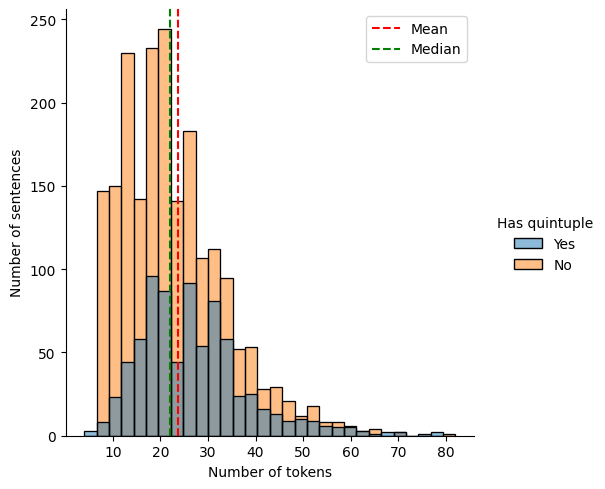

In [39]:
## Size of sentences

sents: list[dict] = [{
    "sentence": sentence,
    "num_of_tokens": len(nltk.word_tokenize(sentence))
} for sentence in train_df.sentence.tolist()]

largest_sent = reduce(lambda max, s: s if max.get("num_of_tokens") < s.get("num_of_tokens") else max, sents)
smallest_sent = reduce(lambda min, s: s if min.get("num_of_tokens") > s.get("num_of_tokens") else min, sents)

print("Sentence with largest number of tokens:")
print(largest_sent) # 82; “ Apple đã tập trung vào việc nâng cao đáng kể Chất lượng hình ảnh tuyệt đối và Độ chính xác màu sắc tuyệt đối của màn hình OLED bằng cách thực hiện hiệu chỉnh màn hình chính xác tại nhà máy , nâng hiệu suất hiển thị tổng thể của iPhone 12 Pro Max lên đến mức độ vượt trội , độ chính xác hoàn hảo đến mức không thể phân biệt bằng mắt thường ” , DisplayMate đánh giá .
print("Sentence with smallest number of tokens:")
print(smallest_sent) # Pin
print()

df = train_df.copy()
df["num_of_tokens"] = [s.get("num_of_tokens") for s in sents]
df["Has quintuple"] = ["Yes" if q is not None else "No" for q in df.quintuples]

print(f"(Test query) {(df.query('num_of_tokens >= 4 & num_of_tokens <= 6'))}")
print(df.describe())

sbn.displot(data=df, x="num_of_tokens", bins=30, kind="hist", hue="Has quintuple")
# plt.legend(title="Have at least 1 quintuple", labels=["True", "False"])
plt.xlabel("Number of tokens")
plt.ylabel("Number of sentences")
plt.axvline(x=np.mean(df.num_of_tokens), color='red', linestyle='--', label='Mean')
plt.axvline(x=np.median(df.num_of_tokens), color='green', linestyle='--', label='Median')
plt.legend()

plt.show()

### 3. Analyzing quintuple fields

Note: may need to validate word's indexes in quintuples

#### a. subject

###### General reviews

- A subject can be:
  - a product name only: "iPhone 12", "iPhone 12 Pro"...
  - a (phrasal) noun: "hai thiết bị", "ảnh", "Mỗi thế hệ iPhone mới"...
  - a phrase showing (owning) relationship between 2 nouns: "điện thoại đắt tiền hơn của Apple", "Các bức ảnh chụp với S20", "Màn hình của Redmi Note 11 Pro +", ...
  - a (phrasal) noun that refers to products mentioned right before it: "Cả 3 chiếc máy", ...
  - more complicated form: "các cổng kết nối cùng nút bấm", "Màn hình đục lỗ không khống chế ở góc màn hình mà lại là chính giữa", "Chip A15 Bionic cung cấp hiệu năng khủng cho iPhone 13", ...
- There're some presences of miss spelling ("ấn tượn" -> "ấn tượng"), lack of spaces ("SEmới) ... This typing errors are trivial & quite rare.

  ⇒ should be corrected.

- Length: 1-16,
  - The distribution is mainly in range 1-6.
  - Subjects with length 9-16 rarely exist.
- Presences of non-word characters ('+', '-', ',', '.', '/', etc):

  ...

- Total of blank subjects / All quintuples: 128/1089
- Total of non-blank unique subjects / Non-blank subjects: 427/961

Longest:
  {'subject': 'Màn hình đục lỗ không khống chế ở góc màn hình mà lại là chính giữa', 'tokens': ['Màn', 'hình', 'đục', 'lỗ', 'không', 'khống', 'chế', 'ở', 'góc', 'màn', 'hình', 'mà', 'lại', 'là', 'chính', 'giữa'], 'length': 16}
Shortest:
  {'subject': 'Xiaomi', 'tokens': ['Xiaomi'], 'length': 1}


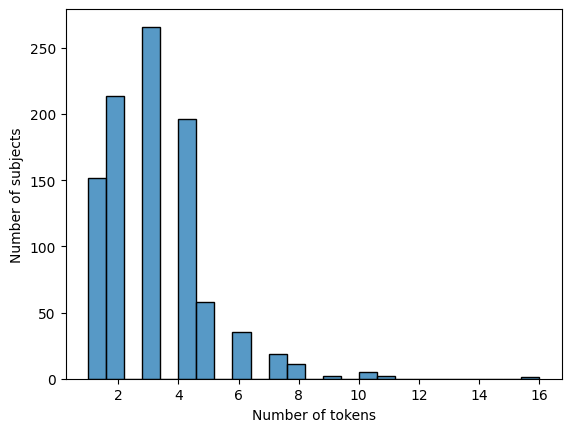

In [31]:
## Initialize dataset ##
flattened_df = pd.DataFrame(flattened_train_dataset)
####

blank_counter = len(flattened_df[flattened_df.subject.str.contains("^\s{0,}$", na=False)])

print(f"- Total of blank subjects / All quintuples: {blank_counter}/{TOTAL_QUINTUPLES}")

df = flattened_df[flattened_df.subject.str.contains("^.{1,}$", na=False)]

subjects = df.subject
unique_subjects = df.subject.unique().tolist()

print(f"- Total of non-blank unique subjects / Non-blank subjects: {len(unique_subjects)}/{len(subjects)}")
print()

tokenized_subjects = []

for s in subjects:
  tokens = nltk.word_tokenize(s)
  tokenized_subjects.append({
      "subject": s,
      "tokens": tokens,
      "length": len(tokens)
  })

longest_subject = reduce(lambda longest, s: s if s.get("length") > longest.get("length") else longest, tokenized_subjects)
shortest_subject = reduce(lambda shortest, s: s if s.get("length") < shortest.get("length") else shortest, tokenized_subjects)

print(f"Longest:\n  {longest_subject}")
print(f"Shortest:\n  {shortest_subject}")

subjects_lengths: list[int] = [s.get("length") for s in tokenized_subjects]

sbn.histplot(pd.Series(subjects_lengths), bins=25)
plt.xlabel("Number of tokens")
plt.ylabel("Number of subjects")
plt.show()

###### BoW & Wordcloud

Conclusions:
- "samsung", "galaxy", "điện", "thoại" ... are some of the most popular words in subjects. => most of datasets come from 'electronic device reviews', especially in topics about 'cellphone', 'camera'.

- Some tuples of words usually stand together, for example:
  - "điện thoại", "sản phẩm", "thiết bị", "xử lý" ... All of these are Vietnamese compound words.

  - "[Samsung] Galaxy [product-line or model-name]": the word "Galaxy" always goes with at least 1 token to indicate a model name or product line.

  - "cả" always goes with other words. in "Cả 2", "cả hai", "cả 3".

  ⇒ Candidates for segmentation.

- Stopword candidates: "này" - 43, "đây" - 16, "chiếc" - 29,

- Non-word characters:
  - Should not remove `',', '.', '/', '+'` although they're minor. The reason is these characters may contribute to a number or product model name.

In [59]:
nonblank_values = flattened_df[flattened_df.subject.str.contains("^.{1,}$", na=False)].subject

In [60]:
""" Bag-of-Words """
subject_bow: dict[str, int] = make_BoW(nonblank_values)
print(subject_bow)
print(f"Size of BoW: {len(subject_bow)}")

{'galaxy': 234, 'ultra': 127, 'samsung': 125, 'pro': 103, 'iphone': 100, 'hai': 89, 'cả': 87, 'điện': 72, 'thoại': 72, 's23': 53, '2': 44, 'này': 43, 'máy': 42, 'nó': 42, 'note': 35, '11': 35, 's22': 35, 'của': 34, '5g': 34, 'xiaomi': 33, '13': 32, 'max': 32, 'chiếc': 29, 'z': 29, 'dòng': 28, 'camera': 27, 's21': 27, 'hình': 23, 'oppo': 23, 'plus': 22, '12': 20, 'điện': 19, 'thoại': 19, '+': 19, 's20': 19, 'smartphone': 18, 'flip': 18, 'find': 18, 'trên': 17, '14': 17, 'redmi': 17, 'màn': 16, 'đây': 16, 'snapdragon': 16, 'mẫu': 16, 'a51': 16, 'pixel': 15, 'ảnh': 15, 'apple': 13, 'a53': 13, 'cả': 12, '8': 12, 'a73': 12, 'các': 12, '20': 12, 'realme': 12, 'sản': 11, 'phẩm': 11, '7': 11, 'mới': 11, 'se': 11, 'n2': 11, 'mi': 11, 's10': 11, 'm51': 11, 'chip': 10, '4': 10, 'a13': 10, 'thiết': 10, 'a32': 10, 'phiên': 10, 'bản': 10, 'a52s': 10, 'a23': 10, 'thiết': 9, 'bị': 9, 'với': 9, 'rog': 9, 'phone': 9, 'fold2': 9, 'fold': 8, 'bị': 8, 'flagship': 8, 'bộ': 8, 'di': 8, 'động': 8, 'googl

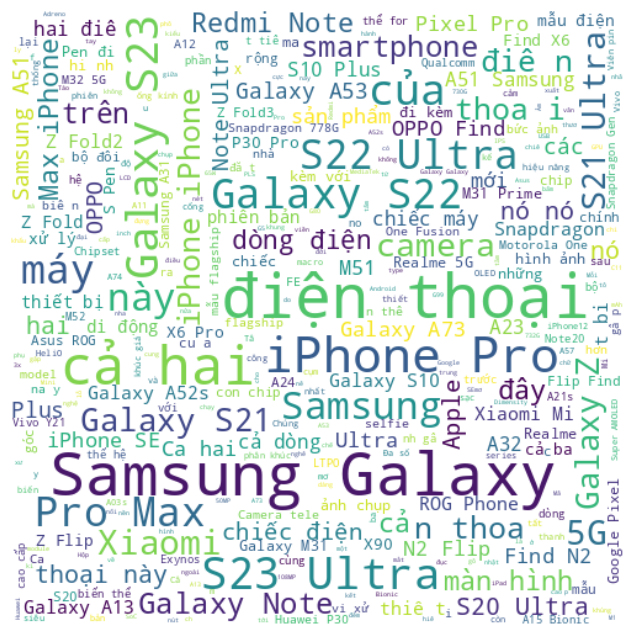

In [61]:
""" Wordcloud """
"Basis of decisions to (1) remove stopwords, special characters & (2) word segmentation"
render_wordcloud(nonblank_values.tolist(), stopwords=[],
                 max_font_size=50, max_words=350, background_color="white")

In [62]:
""" Examine several single words or characters manually """
# Put word or character between 2 '.{0,}'. For example: ".{0,}xiao.{0,}"
# List of recommended non-word characters: \\. , / \\+ -
# List of words: depend on bag of words & wordcloud; note that the word must be lowercase.
filt = [s for s in nonblank_values if re.match(".{0,}chiếc.{0,}", s.lower())]
len(filt)

29

#### b. object

###### General reviews

- An object can be:
  - a product name only: "iPhone 12", "iPhone 12 Pro", "A73", ...
  - a (phrasal) noun: "hai thiết bị", "ảnh", "Mỗi thế hệ iPhone mới", ...
  - a (phrasal) noun that refers to products mentioned right before it: "Cả 2", "cả hai", ...
  - a phrase showing (owning) relationship between 2 nouns: "tổ hợp zoom 3X + 10X trên Galaxy", 'những chiếc máy khác sử dụng " thuật toán AI "',...
  - more complicated form: "các cổng kết nối cùng nút bấm", "các màn hình có tốc độ làm mới 90 Hz hay 120 Hz của Realme hoặc Xiaomi", "ống kính full-frame f / 6.5", ...

- An object may be placed before subject in a sentence. E.g. "Cả 2", ...
- Length: 1-17
  - The distribution is mainly in range 1-6. (number?)
  - Subjects with length 12-17 rarely exist. (number?)
- Presences of non-word characters:
    ...

- Total of blank objects / All quintuples: 468/1089
- Total non-blank unique object / Non-blank objects: 355/621
Longest:
  {'object': 'các màn hình có tốc độ làm mới 90 Hz hay 120 Hz của Realme hoặc Xiaomi', 'tokens': ['các', 'màn', 'hình', 'có', 'tốc', 'độ', 'làm', 'mới', '90', 'Hz', 'hay', '120', 'Hz', 'của', 'Realme', 'hoặc', 'Xiaomi'], 'length': 17}
Shortest:
  {'object': 'Galaxy', 'tokens': ['Galaxy'], 'length': 1}



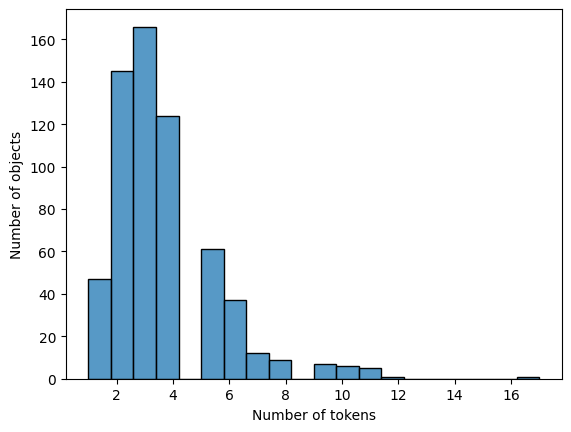

In [ ]:
## Initialize dataset ##
flattened_df = pd.DataFrame(flattened_train_dataset)
####

blank_counter = len(flattened_df[flattened_df.object.str.contains("^\s{0,}$", na=False)])

print(f"- Total of blank objects / All quintuples: {blank_counter}/{TOTAL_QUINTUPLES}")

# Filter out blank strings
df = flattened_df[flattened_df.object.str.contains("^.{1,}$", na=False)]

objects = df.object
unique_objects = objects.unique().tolist()

print(f"- Total non-blank unique object / Non-blank objects: {len(unique_objects)}/{len(objects)}")

tokenized_objects = []

for s in objects:
  tokens = nltk.word_tokenize(s)
  tokenized_objects.append({
      "object": s,
      "tokens": tokens,
      "length": len(tokens)
  })

longest_object = reduce(lambda longest, s: s if s.get("length") > longest.get("length") else longest, tokenized_objects)
shortest_object = reduce(lambda shortest, s: s if s.get("length") < shortest.get("length") else shortest, tokenized_objects)

print(f"Longest:\n  {longest_object}")
print(f"Shortest:\n  {shortest_object}\n")

objects_lengths: list[int] = [s.get("length") for s in tokenized_objects]

sbn.histplot(pd.Series(objects_lengths), bins=20)
plt.xlabel("Number of tokens")
plt.ylabel("Number of objects")
plt.show()

###### BoW & Wordcloud

Conclusions:
- "samsung", "galaxy", "điện", "thoại", "cả" ... are some of the most popular words in objects.

- Some tuples of words usually stand together, for example:
  - "điện thoại", "sản phẩm", "thiết bị", "xử lý", "thế hệ", "tiền nhiệm" ... All of these are Vietnamese compound words; member words always stand together.

  - "[Samsung] Galaxy [product-line or model-name]": the word "Galaxy" *almost* goes with at least 1 token to indicate a model name or product line.

  - "cả" always goes with other words. in "Cả 2", "cả hai", "cả 3".

  ⇒ Candidates for segmentation.

- Stopword candidates: "này" - 43, "đây" - 16, "là" - 1, "chiếc" - 25,

- Non-word characters:
  - Should not remove `',', '.', '/', '+'` although they're minor. The reason is these characters may contribute to a number or product model name.

In [55]:
# Execute this first
nonblank_values = flattened_df[flattened_df.object.str.contains("^.{1,}$", na=False)].object

In [56]:
""" Bag-of-Words """
object_bow: dict[str, int] = make_BoW(nonblank_values)
print([i for i in object_bow.items() if i[1] < 3])
print(f"Size of BoW: {len(object_bow)}")

[('khả', 2), ('năng', 2), ('inch', 2), ('bản', 2), ('ghz', 2), ('điểm', 2), ('số', 2), ('a16', 2), ('người', 2), ('mình', 2), ('hệ', 2), ('đó', 2), ('n2', 2), ('bình', 2), ('con', 2), ('chipset', 2), ('a14', 2), ('đêm', 2), ('chúng', 2), ('mediatek', 2), ('a74', 2), ('xs', 2), ('tất', 2), ('thông', 2), ('kế', 2), ('20', 2), ('a52s', 2), ('dòng', 2), ('s10e', 2), ('hiện', 2), ('mới', 2), ('mặt', 2), ('adreno', 2), ('hz', 2), ('hay', 2), ('vivo', 2), ('ngày', 2), ('hôm', 2), ('đại', 2), ('diện', 2), ('ống', 2), ('kính', 2), ('full-frame', 2), ('f', 2), ('m1', 2), ('ipad', 2), ('``', 2), ('a03s', 2), ('a57', 2), ('5', 2), ('s22', 2), ('hùng', 2), ('mạnh', 2), ('m32', 2), (',', 2), ('trung', 2), ('9', 2), ('9000', 2), ('mini', 2), ('micro-usb', 2), ('ips', 2), ('hàng', 2), ('a21s', 1), ('điều', 1), ('kiện', 1), ('ánh', 1), ('sáng', 1), ('yếu', 1), ('giá', 1), ('rẻ', 1), ('mới', 1), ('nhất', 1), ('mẫu', 1), ('đắt', 1), ('2020', 1), ('ảnh', 1), ('rộng', 1), ('6,8', 1), ('biến',

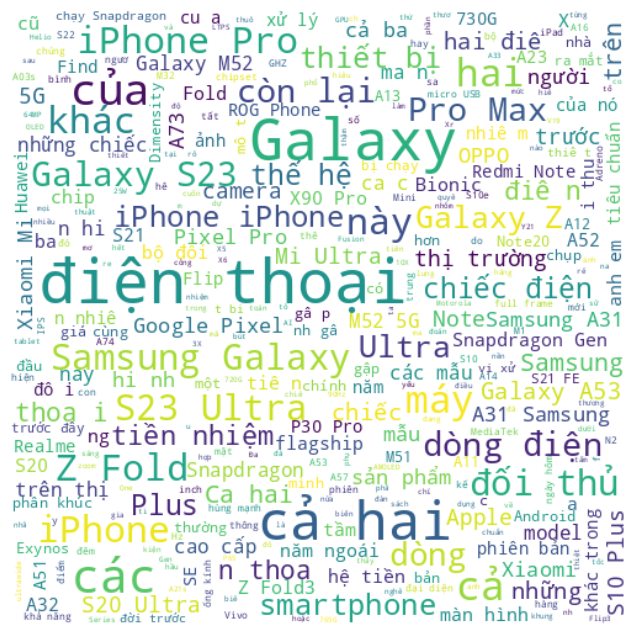

In [57]:
""" Wordcloud """
"Basis of decisions to (1) remove stopwords, special characters & (2) word segmentation"
render_wordcloud(nonblank_values.tolist(), stopwords=[],
                 max_font_size=50, max_words=350, background_color="white")

In [58]:
""" Examine several single words or characters manually """
# Put word or character between 2 '.{0,}'. For example: ".{0,}xiao.{0,}"
# List of recommended non-word characters: \\. , / \\+ - \" (1)
# List of words: depend on bag of words & wordcloud; note that the word must be lowercase.
# considered words: có đi với đang "có mặt"
filt = [s for s in nonblank_values if re.match(".{0,}thoại.{0,}", s.lower())]
filt

['các điện thoại khác trong phân khúc',
 'Cả hai điện thoại',
 'camera trước của điện thoại màn hình gập',
 'các dòng điện thoại trước đây',
 '2 dòng điện thoại',
 'Cả 2 dòng điện thoại',
 'Cả 2 dòng điện thoại',
 'chiếc điện thoại trước đó',
 'cả 2 dòng điện thoại này',
 'Cả 2 chiếc điện thoại',
 'Cả 2 dòng điện thoại',
 'Cả 2 dòng điện thoại',
 'Cả hai điện thoại',
 'những chiếc điện thoại bình thường',
 'những chiếc điện thoại bình thường',
 'chiếc điện thoại gập còn lại',
 'chiếc điện thoại gập còn lại',
 'cả hai điện thoại',
 'Cả 2 chiếc điện thoại',
 'Cả 2 chiếc điện thoại',
 'chiếc điện thoại nào trên thị trường',
 'dòng điện thoại này',
 'các dòng điện thoại khác',
 'các dòng điện thoại khác',
 'các điện thoại còn lại',
 'cả 2 dòng điện thoại',
 '2 dòng điện thoại này',
 'cả 2 dòng điện thoại này',
 'cả 2 dòng điện thoại này',
 'cả 3 điện thoại của dòng iPhone 11',
 'Đa số các dòng điện thoại',
 'Cả 2 dòng điện thoại',
 'tất cả các dòng điện thoại về sau của Apple',
 'cả hai

#### c. aspect

###### General reviews *(not modified yet)*

- An aspect can be:
  - a product name only: "iPhone 12", "iPhone 12 Pro", "A73", ...
  - a (phrasal) noun: "hai thiết bị", "ảnh", "Mỗi thế hệ iPhone mới", ...
  - a (phrasal) noun that refers to products mentioned right before it: "Cả 2", "cả hai", ...
  - a phrase showing (owning) relationship between 2 nouns: "tổ hợp zoom 3X + 10X trên Galaxy", 'những chiếc máy khác sử dụng " thuật toán AI "',...
  - more complicated form: "các cổng kết nối cùng nút bấm", "các màn hình có tốc độ làm mới 90 Hz hay 120 Hz của Realme hoặc Xiaomi", "ống kính full-frame f / 6.5", ...

- An aspect may be placed before subject in a sentence. E.g. "Cả 2", ...
- Length: 1-17
  - The distribution is mainly in range 1-6. (number?)
  - Subjects with length 12-17 rarely exist. (number?)
- Presences of non-word characters:
    ...

- Total of blank aspects / All quintuples: 154/1089
- Total non-blank unique aspect / Non-blank aspects: 564/935
Longest:
  {'aspect': 'khả năng tái tạo màu sắc chính xác và ổn định trong hầu hết mọi điều kiện', 'tokens': ['khả', 'năng', 'tái', 'tạo', 'màu', 'sắc', 'chính', 'xác', 'và', 'ổn', 'định', 'trong', 'hầu', 'hết', 'mọi', 'điều', 'kiện'], 'length': 17}
Shortest:
  {'aspect': 'giá', 'tokens': ['giá'], 'length': 1}



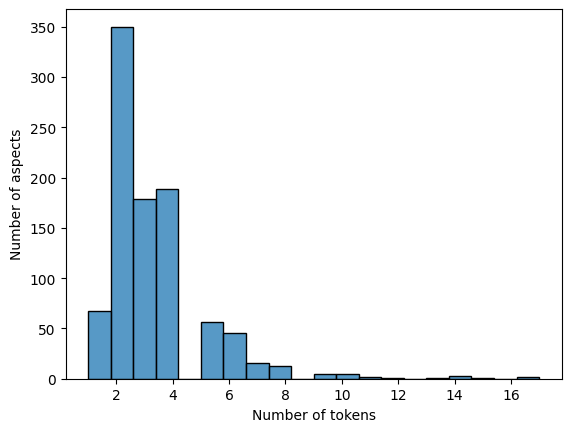

In [38]:
## Initialize dataset ##
flattened_df = pd.DataFrame(flattened_train_dataset)
####

blank_counter = len(flattened_df[flattened_df.aspect.str.contains("^\s{0,}$", na=False)])

print(f"- Total of blank aspects / All quintuples: {blank_counter}/{TOTAL_QUINTUPLES}")

# Filter out blank strings
df = flattened_df[flattened_df.aspect.str.contains("^.{1,}$", na=False)]

aspects = df.aspect
unique_aspects = aspects.unique().tolist()

print(f"- Total non-blank unique aspect / Non-blank aspects: {len(unique_aspects)}/{len(df)}")

tokenized_aspects = []

for s in aspects:
  tokens = nltk.word_tokenize(s)
  tokenized_aspects.append({
      "aspect": s,
      "tokens": tokens,
      "length": len(tokens)
  })

longest_aspect = reduce(lambda longest, s: s if s.get("length") > longest.get("length") else longest, tokenized_aspects)
shortest_aspect = reduce(lambda shortest, s: s if s.get("length") < shortest.get("length") else shortest, tokenized_aspects)

print(f"Longest:\n  {longest_aspect}")
print(f"Shortest:\n  {shortest_aspect}\n")

aspects_lengths: list[int] = [s.get("length") for s in tokenized_aspects]

sbn.histplot(pd.Series(aspects_lengths), bins=20)
plt.xlabel("Number of tokens")
plt.ylabel("Number of aspects")
plt.show()

###### BoW & Wordcloud *(not modified yet)*

Conclusions:
- "samsung", "galaxy", "điện", "thoại" ... are some of the most popular words in aspects.

- Some tuples of words usually stand together, for example:
  - "điện thoại", "sản phẩm", "thiết bị", "xử lý", "tiền nhiệm", "thế hệ", "thị trường" ... All of these are Vietnamese compound words.

  - "[Samsung] Galaxy [product-line or model-name]": the word "Galaxy" *almost* goes with at least 1 token to indicate a model name or product line.

  - "cả" always goes with other words. in "Cả 2", "cả hai", "cả 3".

  ⇒ Candidates for segmentation.

- Stopword candidates: "này" - 43, "đây" - 16, "là" - 1, "chiếc" - 25,

- Non-word characters:
  - Should not remove `',', '.', '/', '+'` although they're minor. The reason is these characters may contribute to a number or product model name.

In [52]:
# Execute this first

## Initialize dataset ##
flattened_df = pd.DataFrame(flattened_train_dataset)
####

nonblank_values = flattened_df[flattened_df.aspect.str.contains("^.{1,}$", na=False)].aspect

In [ ]:
""" Bag-of-Words """
aspect_bow: dict[str, int] = make_BoW(nonblank_values)
print([i for i in aspect_bow.items() if i[1] > 6])
print(f"Size of BoW: {len(aspect_bow)}")

[('hình', 118), ('năng', 94), ('lượng', 80), ('độ', 76), ('màn', 75), ('ảnh', 73), ('camera', 69), ('pin', 63), ('khả', 45), ('chụp', 41), ('chất', 39), ('hiệu', 36), ('kế', 35), ('thiết', 34), ('sạc', 32), ('số', 30), ('mức', 27), ('các', 25), ('kích', 24), ('giá', 24), ('dung', 24), ('bộ', 24), ('thước', 23), ('giải', 22), ('phần', 22), ('phân', 22), ('cảm', 20), ('mặt', 20), ('màu', 19), ('biến', 18), ('sáng', 18), ('tiết', 18), ('thời', 18), ('thông', 17), ('lý', 17), ('chính', 16), ('hình', 16), ('điểm', 16), ('hiển', 16), ('thị', 16), ('tốc', 16), ('xử', 16), ('sắc', 15), ('sau', 14), ('không', 14), ('đa', 14), ('chi', 13), ('và', 12), ('trong', 12), ('công', 12), ('chip', 12), ('động', 12), ('trước', 11), ('mới', 11), ('suất', 11), ('máy', 11), ('lượng', 11), ('cấu', 11), ('tính', 11), ('cụm', 11), ('định', 10), ('selfie', 10), ('màn', 10), ('dây', 10), ('này', 10), ('cứng', 10), ('kính', 10), ('những', 10), ('tối', 10), ('nhanh', 10), ('làm', 10), ('ổn', 9), ('hệ', 9), ('ngh

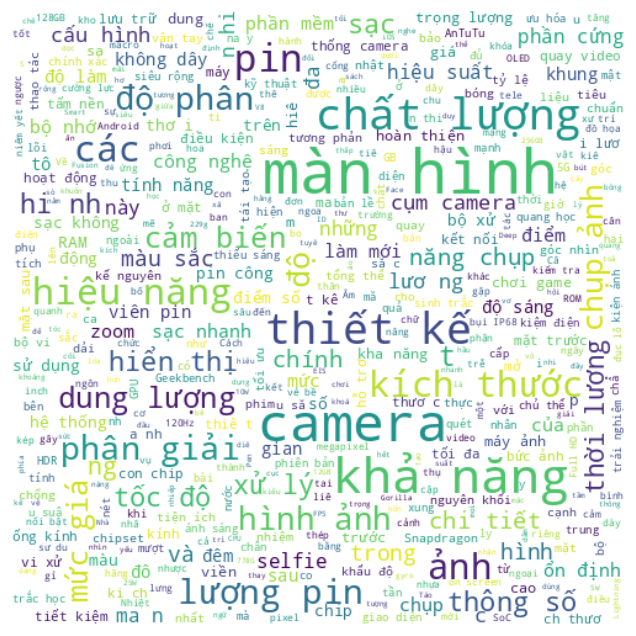

In [54]:
""" Wordcloud """
"Basis of decisions to (1) remove stopwords, special characters & (2) word segmentation"
render_wordcloud(nonblank_values.tolist(), stopwords=[],
                 max_font_size=50, max_words=450, background_color="white")

In [ ]:
""" Examine several single words or characters manually """
# Put word or character between 2 '.{0,}'. For example: ".{0,}xiao.{0,}"
# List of recommended non-word characters: \\. , / \\+ - \" (1)
# List of words: depend on bag of words & wordcloud; note that the word must be lowercase.
# considered words: có đi với đang "có mặt"
filt = [s for s in nonblank_values if re.match(".{0,}hệ.{0,}", s.lower())]
filt

#### d. predicate

###### General reviews *(not modified yet)*

- A predicate can be:
  - a product name only: "iPhone 12", "iPhone 12 Pro", "A73", ...
  - a (phrasal) noun: "hai thiết bị", "ảnh", "Mỗi thế hệ iPhone mới", ...
  - a (phrasal) noun that refers to products mentioned right before it: "Cả 2", "cả hai", ...
  - a phrase showing (owning) relationship between 2 nouns: "tổ hợp zoom 3X + 10X trên Galaxy", 'những chiếc máy khác sử dụng " thuật toán AI "',...
  - more complicated form: "các cổng kết nối cùng nút bấm", "các màn hình có tốc độ làm mới 90 Hz hay 120 Hz của Realme hoặc Xiaomi", "ống kính full-frame f / 6.5", ...

- A predicate may be placed before subject in a sentence. E.g. "Cả 2", ...
- Length: 1-17
  - The distribution is mainly in range 1-6. (number?)
  - Subjects with length 12-17 rarely exist. (number?)
- Presences of non-word characters:
    ...

- Total of blank predicates / All quintuples: 0/1089
- Total non-blank unique predicate / Non-blank predicates: 630/1089
Longest:
  {'predicate': 'đều được sử dụng chip Snapdragon 8 Gen 2 mới nhất của Qualcomm với các lõi được ép xung', 'tokens': ['đều', 'được', 'sử', 'dụng', 'chip', 'Snapdragon', '8', 'Gen', '2', 'mới', 'nhất', 'của', 'Qualcomm', 'với', 'các', 'lõi', 'được', 'ép', 'xung'], 'length': 19}
Shortest:
  {'predicate': 'cao', 'tokens': ['cao'], 'length': 1}



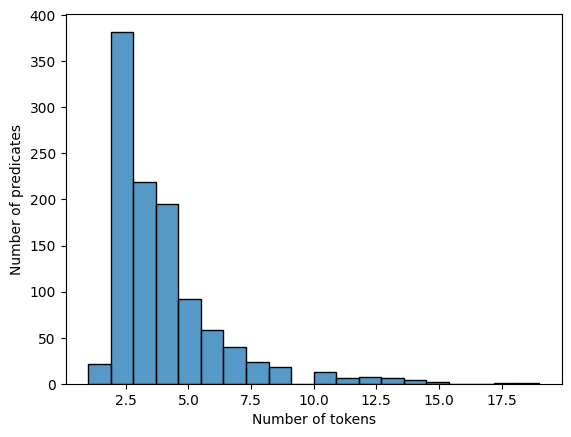

In [39]:
## Initialize dataset ##
flattened_df = pd.DataFrame(flattened_train_dataset)
####

blank_counter = len(flattened_df[flattened_df.predicate.str.contains("^\s{0,}$", na=False)])

print(f"- Total of blank predicates / All quintuples: {blank_counter}/{TOTAL_QUINTUPLES}")

# Filter out blank strings
df = flattened_df[flattened_df.predicate.str.contains("^.{1,}$", na=False)]

predicates = df.predicate
unique_predicates = predicates.unique().tolist()

print(f"- Total non-blank unique predicate / Non-blank predicates: {len(unique_predicates)}/{len(df)}")

tokenized_predicates = []

for s in predicates:
  tokens = nltk.word_tokenize(s)
  tokenized_predicates.append({
      "predicate": s,
      "tokens": tokens,
      "length": len(tokens)
  })

longest_predicate = reduce(lambda longest, s: s if s.get("length") > longest.get("length") else longest, tokenized_predicates)
shortest_predicate = reduce(lambda shortest, s: s if s.get("length") < shortest.get("length") else shortest, tokenized_predicates)

print(f"Longest:\n  {longest_predicate}")
print(f"Shortest:\n  {shortest_predicate}\n")

predicates_lengths: list[int] = [s.get("length") for s in tokenized_predicates]

sbn.histplot(pd.Series(predicates_lengths), bins=20)
plt.xlabel("Number of tokens")
plt.ylabel("Number of predicates")
plt.show()

###### BoW & Wordcloud *(not modified yet)*

Conclusions:
- "so với", "so sánh", "hơn", "chút", "tốt", "nhất", "không" ... are some of the most popular words in predicates.

- Some tuples of words usually stand together, for example:
  - "một chút", "mạnh mẽ", "", "chi tiết", "tiết kiệm", "thế hệ", "thị trường", "xử lý", "tương đồng", "tương tự", "màu sắc", "sắc nét", "sử dụng", "hiện nay", "hiện tại", ... All of these are Vietnamese compound words.

  - "[Samsung] Galaxy [product-line or model-name]": the word "Galaxy" *almost* goes with at least 1 token to indicate a model name or product line.

  ⇒ Candidates for segmentation.

- Stopword candidates: "này" - 43, "đây" - 16, "là" - 1, "chiếc" - 25, "cả" - 2

- Non-word characters:
  - Should not remove `',', '.', '/', '+'` although they're minor. The reason is these characters may contribute to a number or product model name.

In [40]:
# Execute this first

## Initialize dataset ##
flattened_df = pd.DataFrame(flattened_train_dataset)
####

nonblank_values = flattened_df[flattened_df.predicate.str.contains("^.{1,}$", na=False)].predicate

In [ ]:
""" Bag-of-Words """
predicate_bow: dict[str, int] = make_BoW(nonblank_values)
print([i for i in predicate_bow.items() if i[1] > 3])
print(f"Size of BoW: {len(predicate_bow)}") # largest in the 4 fields of quin

[('hơn', 501), ('tốt', 117), ('đều', 109), ('nhất', 105), ('có', 89), ('không', 82), ('cao', 74), ('nhiều', 71), ('như', 47), ('khác', 45), ('được', 44), ('tương', 44), ('vượt', 43), ('một', 39), ('trội', 38), ('biệt', 38), ('cấp', 36), ('lớn', 36), ('nay', 35), ('mạnh', 31), ('hiện', 31), ('nhau', 30), ('sự', 30), ('chút', 30), ('thế', 28), ('rất', 26), ('nhỉnh', 25), ('nhanh', 25), ('và', 25), ('giống', 23), ('bị', 23), ('trên', 21), ('trong', 21), ('thấp', 21), ('khá', 20), ('là', 19), ('ngang', 19), ('kém', 19), ('chi', 19), ('đều', 18), ('mẽ', 18), ('với', 18), ('trang', 18), ('nâng', 17), ('gần', 17), ('tiết', 17), ('sở', 17), ('của', 17), ('nhỏ', 16), ('so', 16), ('thể', 15), ('đáng', 15), ('lượng', 15), ('hữu', 15), ('cải', 15), ('đương', 15), ('chênh', 14), ('về', 13), ('thị', 13), ('nhẹ', 13), ('đồng', 13), ('phân', 13), ('tiến', 13), ('được', 12), ('dụng', 12), ('cùng', 12), ('sáng', 12), ('lợi', 12), ('rẻ', 12), ('phần', 11), ('trường', 11), ('smartphone', 11), ('bằng', 1

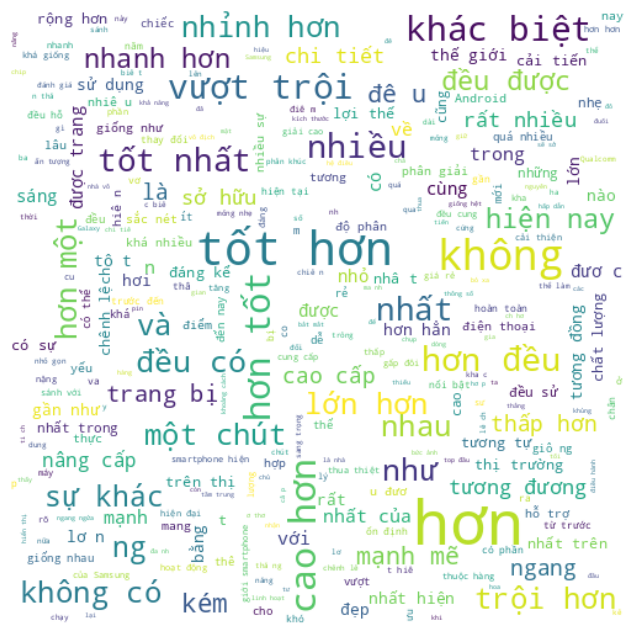

In [51]:
""" Wordcloud """
"Basis of decisions to (1) remove stopwords, special characters & (2) word segmentation"
render_wordcloud(nonblank_values.tolist())

In [35]:
""" Examine several single words or characters manually """
# Put word or character between 2 '.{0,}'. For example: ".{0,}xiao.{0,}"
# List of recommended non-word characters: \\. , / \\+ - \" (1)
# List of words: depend on bag of words & wordcloud; note that the word must be lowercase.
# considered words: khác biệt, không có,...

# filt = [s for s in nonblank_values if re.match(".{0,}hiện.{0,}", s.lower())]

# Use some keywords of the DIF predicates to query predicates of other labels
print("Predicates of 'DIF':")
print(flattened_df.loc[[i for i, v in flattened_df.predicate.items() if re.match(".{0,}.{0,}", str(v).lower())]].query("label == 'DIF'").predicate.unique())

print("\nPredicates of EQL:")
print(flattened_df.loc[[i for i, v in flattened_df.predicate.items() if re.match(".{0,}(không)|(khác)|(chênh).{0,}", str(v).lower())]].query("label == 'EQL'").predicate.unique())

print("\nPredicates of COM:")
print(flattened_df.loc[[i for i, v in flattened_df.predicate.items() if re.match(".{0,}(không)|(khác)|(chênh).{0,}", str(v).lower())]].query("label.str.contains('COM', na=False)").predicate.unique())

# Query original sentences
# flattened_df.loc[[i for i, v in flattened_df.predicate.items() if re.match(".{0,}(khác)|(chênh).{0,}", str(v).lower())]].query("label == 'EQL'")
# filt

Predicates of 'DIF':
['hiếm có chiếc điện thoại nào trên thị trường có thể làm được' 'thiếu'
 'ngược lại' 'khác biệt dễ nhận thấy' 'không hoàn toàn ngang bằng'
 'chênh lệch rõ ràng' 'không có' 'lột xác hoàn toàn'
 'không bị ngả sang tone vàng như' 'không bị bệt hay mất chi tiết như'
 'sự thay đổi đáng kể' 'khác biệt'
 'một trong những điểm khác biệt dễ thấy nhất' 'sự khác biệt đáng kể'
 'không còn như xưa' 'không đều'
 'không có khả năng sạc nhanh vượt trội như' 'khác biệt rõ ràng'
 'không giống như' 'Khác biệt' 'điểm khác biệt lớn nhất' 'rất khác nhau'
 'khác biệt đáng kể' 'Khác' 'có một khoảng cách' 'thay đổi' 'khác biệt'
 'không hề có một chiếc tai thỏ nào' 'Không sở hữu sự tương đồng'
 'Điểm khác biệt' 'nhiều sự khác biệt hơn thế' 'sự khác nhau'
 'Điểm khác biệt lớn nhất' 'không được xử lý như' 'hơi lạ'
 'hơi dịch lên phía trên một chút' 'có sự khác biệt' 'khác nhau'
 'sự khác biệt rõ ràng nhất' 'có sự chênh lệch khá lớn'
 'không có tính năng tương tự' 'không có nh

#### e. label

Do labels relate to the existences of remaining fields?

List some following information of the 4 remaining fields for each label type:
- predicate: most popular words (may render cloudword)
- frequencies of existences of the 3 fields (subject, object, aspect)
- subject & object: most popular (compound) words (?)


**Idea**:

Due to the fact that:
- predicate always exists in a quintuple
- subject, object & aspect may be absent concurrently

we can scan/identify "predicate candidates" to divide sentences into 3 groups. In each of groups, they will be continously classified into 1 of 9 labels (NON included) by resolving *sub-problems*.
- Group 1: Equal-comparative (ECOM); including EQL & DIF
- Group 2: Comparative (COM); including
  - COM-: negative
  - COM: neutral
  - COM+: positive
- Group 3: Superlative(SUP); including
  - SUP-: negative
  - SUP: neutral
  - SUP+: positive
- Group 4: Non-comparative (NON)

After having 4 groups:
- in the group 1, we'll need to resolve the *binary classification* problem.
- in the group 2 & 3, we'll need to resolve the *Sentimental Classification* problem.


others problems:
- what if 1 sentence provides 2 quintuples that possess the same predicate (subjects/objects/aspect may be diff)? Can the labels be diff in this case?


##### Init & creating helper functions

In [31]:
## Initialize dataset ##
flattened_df = pd.DataFrame(flattened_train_dataset)
####

blank_counter = len(flattened_df[flattened_df.label.str.contains("^\s{0,}$", na=False)])

print(f"- Total of blank labels / All quintuples: {blank_counter}/{TOTAL_QUINTUPLES}")

labels = flattened_df[flattened_df.label.str.contains("^.{1,}$", na=False)].label.unique().tolist()

groups = ["NON", "COM", "SUP"]
ecom_df = flattened_df[flattened_df.label.str.match("(DIF)|(EQL)", na=False)]
com_df = flattened_df[flattened_df.label.str.contains("COM", na=False)]
sup_df = flattened_df[flattened_df.label.str.contains("SUP", na=False)]

- Total of blank labels / All quintuples: 0/1089


In [ ]:
def calc_BoW(field: str, label: str, df: pd.DataFrame = flattened_df):
  allowed_fields = ["subject", "object", "aspect", "predicate"]

  assert field in allowed_fields, (
      f"Input field must be one of {allowed_fields}"
  )
  assert label in labels, f"Label must be one of {labels}"

  return make_BoW(df[df.label == label][field])

def calc_frequency(field: str, label: str, df: pd.DataFrame = flattened_df):
  allowed_fields = ["subject", "object", "aspect"]

  assert field in allowed_fields, (
      f"Input field must be one of {allowed_fields}"
  )
  assert label in labels, f"Label must be one of {labels}"


  df_l = df[df.label == label]
  df_f = df_l[df_l[field].str.contains("^.{1,}$", na=False)]

  return len(df_f)

# Test
# calc_frequency("subject", "SUP")

##### i. Counting quintuples & sentences on each type of label
Main function: `relate_labels_with_others(flattened_df: pd.DataFrame)`

Present num_of_data_points (number of quintuples) and num_of_sentences on each label type:
(group 'SUP-' and 'SUP')
        label  num_of_data_points  num_of_sentences
0        COM+                 500               371
1         EQL                 287               249
2        SUP+                 107                87
3        COM-                 107                86
4         DIF                  58                52
5         COM                  21                19
6  SUP- & SUP                   9                 8



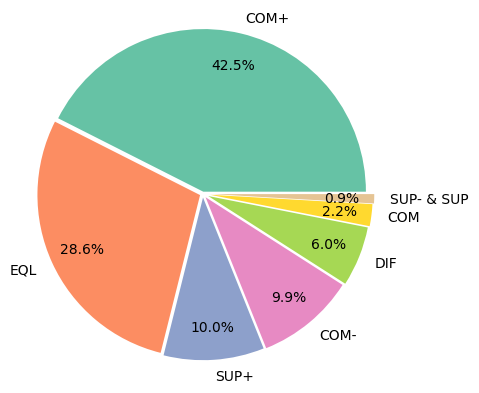

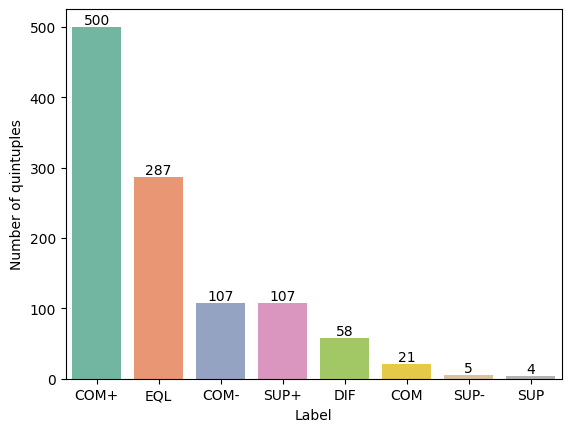

In [ ]:
flattened_df = pd.DataFrame(flattened_train_dataset)

def relate_labels_with_others(flattened_df: pd.DataFrame):
  statistic: list[dict] = [{
      "label": label,
      "num_of_data_points": len(flattened_df[flattened_df.label == label]),
      "num_of_sentences": len(flattened_df[flattened_df.label == label].sentence.unique())

  } for label in list(flattened_df[flattened_df.label.str.contains("^.{1,}$", na=False)].label.unique())]

  statistic = pd.DataFrame(statistic).sort_values(by="num_of_data_points", ascending=False)

  print("Present num_of_data_points (number of quintuples) and num_of_sentences on each label type:")
  # print(statistic)
  # print()

  ## Group SUP- & SUP (each has 4 sentences) before rendering
  x = statistic.set_index("label").drop(["SUP-", "SUP"]).reset_index()
  minor_data = statistic[statistic.label.str.match("^(SUP-)|(SUP)$", na=False)]#.reset_index()
  minor_data_grouping_point = pd.DataFrame([{
      "label": "SUP- & SUP",
      "num_of_data_points": reduce(lambda acc, val: acc + val, minor_data["num_of_data_points"].tolist()),
      "num_of_sentences": reduce(lambda acc, val: acc + val, minor_data["num_of_sentences"].tolist())
  }])

  x = pd.concat([x, minor_data_grouping_point], ignore_index=True)
  print(f"(group 'SUP-' and 'SUP')\n{x}\n")

  ## Render diagrams
  color_pallete = sbn.color_palette('Set2')
  explodes = [0.015, 0.02, 0.025, 0.03, 0.04, 0.05, 0.06]

  plt.pie(x["num_of_sentences"], labels=x.label.tolist(),
          colors=color_pallete, autopct='%.1f%%',
          radius=1.1, pctdistance=0.8, labeldistance=1.1, explode=explodes, shadow=False)
  # plt.title('Số lượng data point trên từng label')
  plt.show()
  print()

  plot = sbn.countplot(flattened_df, x = "label", # ignore NaN, None by default
                      order=list(flattened_df.value_counts("label").index),
                      palette=color_pallete)
  plot.set(title = "", xlabel = "Label", ylabel = "Number of quintuples") # may contains duplicate sentences
  plot.bar_label(plot.containers[0])

  plt.show()

relate_labels_with_others(flattened_df)

##### ii. Counting quintuples & sentences in each group
Main function: `relate_groups_with_quin_and_sent(flattened_df: pd.DataFrame)`

In [ ]:
flattened_df = pd.DataFrame(flattened_train_dataset)

def relate_groups_with_quin_and_sent(flattened_df: pd.DataFrame):
  statistic: list[dict] = [{
      "group": "SUP (Superlative)",
      "num_of_data_points": len(sup_df),
      "num_of_sentences": len(sup_df.sentence.unique())
  }]

  statistic.append({
      "group": "COM (Comparative)",
      "num_of_data_points": len(com_df),
      "num_of_sentences": len(com_df.sentence.unique())

  })

  statistic.append({
      "group": "NON (Non-comparative)",
      "num_of_data_points": len(ecom_df),
      "num_of_sentences": len(ecom_df.sentence.unique())
  })

  statistic = pd.DataFrame(statistic).sort_values(by="num_of_data_points", ascending=False)

  print("Present num_of_data_points (number of quintuples) and num_of_sentences on each group:")
  print(statistic)
  print()

  ## Render diagrams
  color_pallete = sbn.color_palette('Set2')
  explodes = [0.015, 0.02, 0.025]

  plt.pie(statistic["num_of_data_points"], labels=statistic.group.tolist(),
          colors=color_pallete, autopct='%.1f%%',
          radius=1, pctdistance=0.8, labeldistance=1.1, explode=explodes, shadow=False)
  plt.title('Số lượng quintuple trên từng label')
  plt.show()
  print()

  # plot = sbn.countplot(flattened_df, x = "label", # ignore NaN, None by default
  #                     order=list(flattened_df.value_counts("label").index),
  #                     palette=color_pallete)
  # plot.set(title = "", xlabel = "Label", ylabel = "Number of quintuples") # may contains duplicate sentences
  # plot.bar_label(plot.containers[0])

  # plt.show()

relate_groups_with_quin_and_sent(flattened_df)

##### iii. Relate labels to the remaining quintuple fields

**Labels vs predicates**
(Common characteristics)
- Predicates in general show key opinions of authors/reviewers about the comparisons between 2 products/product lines...
- In predicates, adverbs along with adjectives takes up most of the words. Specifically, some of them are:
  - Adverbs of degree: hơi, rất, khá, nhất
  - Adverbs of manner: tốt
  - Adjectives (may be specific to context): mạnh mẽ, khác biệt

**Labels vs subjects**

**Labels vs objects**

**Labels vs aspects**


###### Non-comparative group

- "EQL" predicates (287q):
  - Keywords:
    - Adj:
      - không có .+ khác biệt
      - không có .+ chênh lệch
      - Tương tự/tương đồng
      - Ngang/giống/bằng nhau
    - Adverb of degree: (không) đáng kể, lớn, nhiều
      ...

- "DIF" predicates (58q):
  - Keywords:
    - Adj: khác biệt, khác nhau, không bằng (như)
    - Adv of degrees: rõ ràng,
    
      ...

- There're ambiguities in classifying label based on predicates.
For example, the sentences with predicate "không có khác biệt" (or similar ones) are mostly considered as "EQL", but sometimes are sorted into "DIF".

|index|sentence|subject|object|aspect|predicate|label|
|---|---|---|---|---|---|---|
|4437|Do sức mạnh đến từ bộ vi xử lý tương tự nhau nên không có nhiều sự khác biệt về khả năng tiết kiệm điện năng \.|||bộ vi xử lý|tương tự nhau|EQL|
|4438|Do sức mạnh đến từ bộ vi xử lý tương tự nhau nên không có nhiều sự khác biệt về khả năng tiết kiệm điện năng \.|||khả năng tiết kiệm điện năng|không có nhiều sự khác biệt|DIF|
|4442|des : Không có nhiều sự khác biệt về khả năng tiết kiệm điện năng|||khả năng tiết kiệm điện năng|Không có nhiều sự khác biệt|EQL|


Label 'DIF' (58):
Some examples:
['hiếm có chiếc điện thoại nào trên thị trường có thể làm được' 'thiếu'
 'ngược lại' 'khác biệt dễ nhận thấy' 'không hoàn toàn ngang bằng'
 'chênh lệch rõ ràng' 'không có' 'lột xác hoàn toàn'
 'không bị ngả sang tone vàng như' 'không bị bệt hay mất chi tiết như'
 'sự thay đổi đáng kể' 'khác biệt'
 'một trong những điểm khác biệt dễ thấy nhất' 'sự khác biệt đáng kể'
 'không còn như xưa' 'không đều'
 'không có khả năng sạc nhanh vượt trội như' 'khác biệt rõ ràng'
 'không giống như' 'Khác biệt' 'điểm khác biệt lớn nhất' 'rất khác nhau'
 'khác biệt đáng kể' 'Khác' 'có một khoảng cách' 'thay đổi' 'khác biệt'
 'không hề có một chiếc tai thỏ nào' 'Không sở hữu sự tương đồng'
 'Điểm khác biệt' 'nhiều sự khác biệt hơn thế' 'sự khác nhau'
 'Điểm khác biệt lớn nhất' 'không được xử lý như' 'hơi lạ'
 'hơi dịch lên phía trên một chút' 'có sự khác biệt' 'khác nhau'
 'sự khác biệt rõ ràng nhất' 'có sự chênh lệch khá lớn'
 'không có tính năng tương tự' 

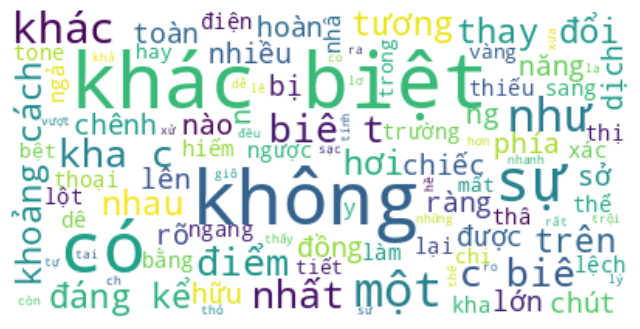




Label 'EQL' (287):
Some examples:
['hầu như không nhận được nâng cấp nào về phần cứng'
 'Đều là những chiếc smartphone dành cho người dùng trẻ' 'tương tự nhau'
 'đều cho' 'như nhau' 'đều mang trên mình' 'đều rất phù hợp'
 'Sự chênh lệch về các thông số khác như camera cũng không đáng kể'
 'được kế thừa' 'Giống với' 'đều là flagship Android' 'ngang'
 'sánh ngang' 'hoàn toàn ngang bằng' 'đều mang đến'
 'chất liệu kính giống' 'đều tích hợp' 'đều sử dụng'
 'đều dựa vào máy quét dấu vân tay dưới màn hình' 'tốt như nhau'
 'không thấy sự chênh lệch đáng kể' 'đều được cung cấp'
 'sự khác biệt về hiệu suất thực tế là không đáng kể' 'có cùng'
 'đều đi kèm với Android' 'không có nhiều chênh lệch đáng kể'
 'gần như ngang nhau khi duyệt web' 'cũng hỗ trợ' 'gần như không đáng kể'
 'gần như là giống nhau hoàn toàn' 'cũng khá giống' 'gần như tương đồng'
 'đều cho chất lượng tốt'
 'đều hỗ trợ quay video với độ phân giải 4K và chống rung OIS'
 'đều được tích hợp' 'cùng sở 

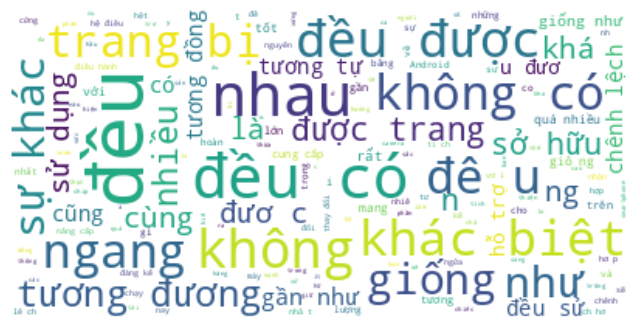

In [ ]:
for label in ["DIF", "EQL"]:
  df_l = flattened_df[flattened_df.label == label]

  print(f"Label '{label}' ({len(df_l)}):")

  print("Some examples:")
  print(df_l.predicate.unique())
  print()

  for field in ["subject", "object", "aspect"]:
    print(f"- Field '{field}':")
    print(f"  + Freq: {calc_frequency(field, label)}")
    print(f"  + BoW:\n    {calc_BoW(field, label)}")

  print("- Field 'predicate':")
  print(f"  + BoW:\n    {calc_BoW('predicate', label)}\n")
  render_wordcloud(df_l[df_l.predicate.str.contains("^.{1,}$", na=False)].predicate.tolist(),
                   stopwords=[],
                   max_font_size=50, max_words=350, background_color="white")
  print("\n\n")

###### Comparative group

- "COM+" predicates - 500q (*positive*):
  - Keywords: "hơn" - 415, tốt - 76, cao - 53, nhiều - 45

- "COM" predicates - 21q (*neutral*):
  - Keywords: "hơn" - 19.

- "COM-" predicates - 107q (*negative*):
  - Keywords: "hơn" - 64, thấp - 21, kém - 19, không - 18, thua - 8, yếu - 8


In [ ]:
for label in ["COM+", "COM", "COM-"]:
  df_l = flattened_df[flattened_df.label == label]

  print(f"Label '{label}' ({len(df_l)}):")

  print("Some examples:")
  [print(f"- {s}") for s in df_l.predicate.unique().tolist()[:10]]
  print()

  for field in ["subject", "object", "aspect"]:
    print(f"- Field '{field}':")
    print(f"  + Freq: {calc_frequency(field, label)}")
    print(f"  + BoW:\n    {calc_BoW(field, label)}")

  print("- Field 'predicate':")
  print(f"  + BoW:\n    {calc_BoW('predicate', label)}\n")
  render_wordcloud(df_l[df_l.predicate.str.contains("^.{1,}$", na=False)].predicate.tolist(),
                   stopwords=[],
                   max_font_size=50, max_words=350, background_color="white")
  print("\n\n")

###### Superlative group

- "SUP+" predicates - 107 (*positive*):
  - Keywords: "nhất" - 85, tốt - 33, nay - 28, hiện - 25, cao - 15, mạnh - 14

- "SUP" predicates - 4 (*neutral*):
  - Keywords: "nhất" - 4, lớn - 2

- "SUP-" predicates - 5 (*negative*):
  - Keywords: "nhất" - 4, nhỏ - 2, đắt - 1



Label 'SUP+' (107):
Some examples:
- tuyệt vời nhất trên thị trường
- hàng đầu
- mạnh mẽ nhất trong thời gian gần đây
- mạnh nhất hiện tại
- đỉnh cao nhất thế giới smartphone hiện tại
- cao nhất
- cao cấp nhất
- tốt nhất
- tốt nhất hiện nay
- hot nhất

- Field 'subject':
  + Freq: 104
  + BoW:
    {'galaxy': 29, 'iphone': 18, 'pro': 18, 'ultra': 18, 'đây': 12, 'max': 10, 'samsung': 10, '12': 7, 's22': 7, 's21': 5, 'z': 5, 'note': 5, '13': 4, 'của': 4, 'hai': 4, 'pixel': 4, '14': 3, 'xiaomi': 3, 'điện': 3, 'thoại': 3, 'apple': 3, 'cả': 3, 'chiếc': 3, '11': 3, '2': 3, 'se': 3, '2016': 3, '5g': 3, 'plus': 3, 'a24': 3, 'm51': 3, '7': 3, 'máy': 2, 'oppo': 2, 'a15': 2, 'bionic': 2, 'cấp': 2, 'thiết': 2, 'bị': 2, 'sản': 2, 'phẩm': 2, 's23': 2, 'fold': 2, '4': 2, 'snapdragon': 2, '20': 2, 'smartphone': 2, 'dòng': 2, 'redmi': 2, 's10': 2, 's20': 2, 'mới': 2, 'rog': 2, 'phone': 2, 'series': 2, 'note20': 2, 'fold3': 2, 'vi': 1, 'xử': 1, 'lý': 1, 'm1': 1, 'trên': 1, 'ipad': 1, 'ba': 1, 'fi

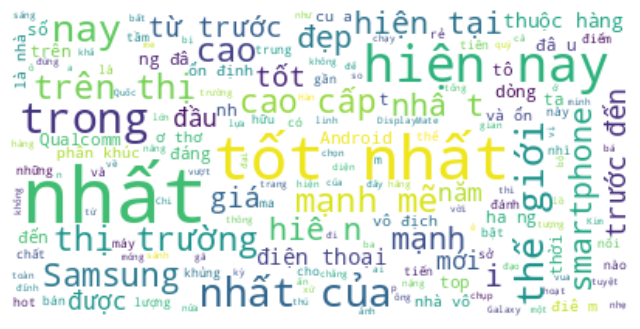




Label 'SUP' (4):
Some examples:
- lớn nhất từ trước đến nay
- nhỏ nhất
- không còn là cấu hình mạnh mẽ nhất trong thế giới smartphone nữa
- lớn nhất trong Galaxy S20 Series vừa ra mắt

- Field 'subject':
  + Freq: 4
  + BoW:
    {'galaxy': 2, 'iphone12': 1, 'pro': 1, 'max': 1, 's23': 1, 'đây': 1, 'hộp': 1, 'đựng': 1, 's20': 1, 'ultra': 1}
- Field 'object':
  + Freq: 0
  + BoW:
    {}
- Field 'aspect':
  + Freq: 4
  + BoW:
    {'hình': 2, 'màn': 1, 'phiên': 1, 'bản': 1, 'cấu': 1, 'kích': 1, 'thước': 1}
- Field 'predicate':
  + BoW:
    {'nhất': 4, 'lớn': 2, 'trong': 2, 'từ': 1, 'trước': 1, 'đến': 1, 'nay': 1, 'nhỏ': 1, 'không': 1, 'còn': 1, 'là': 1, 'cấu': 1, 'hình': 1, 'mạnh': 1, 'mẽ': 1, 'thế': 1, 'giới': 1, 'smartphone': 1, 'nữa': 1, 'galaxy': 1, 's20': 1, 'series': 1, 'vừa': 1, 'ra': 1, 'mắt': 1}



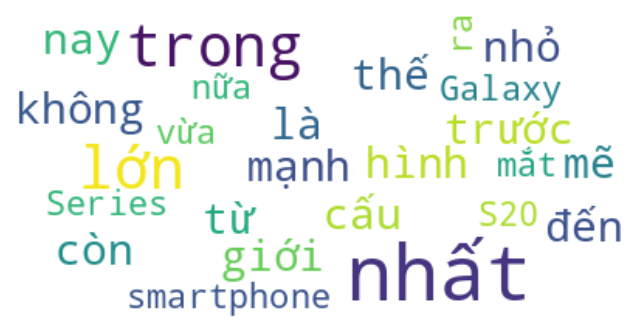




Label 'SUP-' (5):
Some examples:
- nhỏ nhất
- đắt nhất của Samsung
- ngắn nhất
- đứng vị trí cuối cùng

- Field 'subject':
  + Freq: 5
  + BoW:
    {'realme': 2, '6': 2, 'pro': 2, 'camera': 1, 'tele': 1, 'galaxy': 1, 'z': 1, 'flip': 1, 'pixel': 1, '5': 1}
- Field 'object':
  + Freq: 0
  + BoW:
    {}
- Field 'aspect':
  + Freq: 4
  + BoW:
    {'pin': 2, 'kích': 1, 'thước': 1, 'cảm': 1, 'biến': 1, 'thời': 1, 'lượng': 1, 'chụp': 1, 'ảnh': 1}
- Field 'predicate':
  + BoW:
    {'nhất': 4, 'nhỏ': 2, 'đắt': 1, 'của': 1, 'samsung': 1, 'ngắn': 1, 'đứng': 1, 'vị': 1, 'trí': 1, 'cuối': 1, 'cùng': 1}



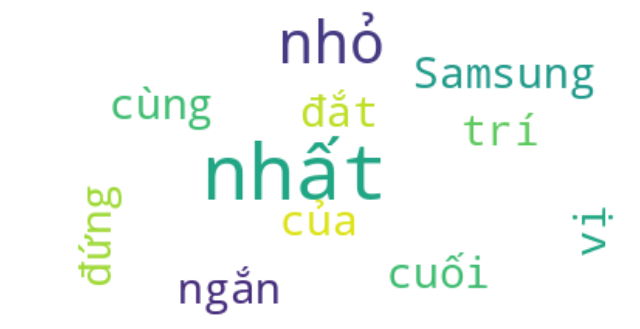

In [ ]:
for label in ["SUP+", "SUP", "SUP-"]:
  df_l = flattened_df[flattened_df.label == label]

  print(f"Label '{label}' ({len(df_l)}):")

  print("Some examples:")
  [print(f"- {s}") for s in df_l.predicate.unique().tolist()[:10]]
  print()

  for field in ["subject", "object", "aspect"]:
    print(f"- Field '{field}':")
    print(f"  + Freq: {calc_frequency(field, label)}")
    print(f"  + BoW:\n    {calc_BoW(field, label)}")

  print("- Field 'predicate':")
  print(f"  + BoW:\n    {calc_BoW('predicate', label)}\n")
  render_wordcloud(df_l[df_l.predicate.str.contains("^.{1,}$", na=False)].predicate.tolist(),
                   stopwords=[],
                   max_font_size=50, max_words=350, background_color="white")
  print("\n\n")

#### Relate the fields to each others



- Incorrect object?

|index|sentence|subject|object|aspect|predicate|label|
|---|---|---|---|---|---|---|
|831|Về chất lượng hiển thị , so sánh iPhone XS và iPhone 11 thì iPhone XS có phần trội hơn \.|iPhone XS|iPhone XS|chất lượng hiển thị|có phần trội hơn|COM+|
|1476|Với điện thoại màn hình gập Galaxy Z Fold 4 sẽ mang đến không gian hiển thị linh hoạt hơn với 2 màn hình \.|điện thoại màn hình gập Galaxy Z Fold 4|điện thoại màn hình gập Galaxy Z Fold 4|không gian hiển thị|linh hoạt hơn|COM+|

In [ ]:
# subject == object: 130
# 128 are either DIF or EQL
# 2 is COM+
# flattened_train_df[flattened_train_df.predicate.notna()].query("subject == object & subject.str.contains('.{1,}', na=False)")



### Exporting dataset

In [42]:
# This output dataset should be result of the "shallow" cleaning process
# performed in the section "I.2. Analyzing sentences" .
train_df.to_csv("post_analysis_training_dataset.csv", index=False)

## II. Analysis on test dataset

In [44]:
# Run this if you want to export the test dataset
test_df.drop("quintuples", axis=1).to_csv("test_dataset.csv", index=False)

In [109]:
# test_df.drop("quintuples", axis=1, inplace=True)
print(len(test_df) == 1732)
test_df.loc[[i for i, v in test_df.sentence.items() if len(nltk.word_tokenize(v)) in range(6)]] # 0-3 chars: 54

True


,sentence,quintuples
3,Thiết kế,None
7,des : iPhone 13,None
14,Màn hình,None
18,des :,None
21,Hiệu năng,None
...,...,...
1706,So sánh với đối thủ,None
1710,Vivo S1 Pro,None
1715,Redmi Note 9 Pro,None
1721,Realme 6 Pro,None


Conclusions: **(not modified yet)**
- Most of the sentences start with a capitalized word and end with a '.' (1004).
- Some are not complete sentence, which may start with not-capitalized word and may not contain subject. e.g.
- Some are combined from 2 sentences. e.g. "".
- Removing characters
  - Special-character candidates: ". . .", " . " (sent separator; rm if num of sent isn't concerned),
  -

In the section 1, we can see an unexpected imbalance between number of sentences not having any quins vs sentences having quins,
where number of zero-quin sentences (3359) is about *4 times* larger than number of sentences with quin (812).

Thus, in this section, we will dive into the sentences to find out *hidden characteristics* of them, by which we may have some bases for making *data cleaning* decisions.

Result: 2819 zero-quin sentences left (540 deleted).

In [124]:
## Initialize dataset
# 'train_df' now store the data from test dataset
# temporarily ignore the variable name 'train_df'; may be changed later
train_df = pd.DataFrame(DatasetUtils.to_multi_quintuples_dict_list(test_dataset))
print(f"Original test dataset's size (before modified): {len(train_df)}")

Original test dataset's size (before modified): 1732


#### General stats (before modified)

##### Distribution of sentence size

Sentence size is calculated by number of tokens.

Conclusion:
- The distribution is quite similar to training dataset.

- Sentence size may be affected by a non-trivial number of non-alphanumeric characters (bracket, comma, quote, etc) (infered from observing both histogram & dataset)
- Sentences's size is mainly in range 10-35, means=18.3, median=17

Sentence with largest number of tokens:
{'sentence': 'Hứa hẹn lớn của Xiaomi 13 Pro chắc chắn là về máy ảnh : bạn có cảm biến máy ảnh chính loại 1 inch , lớn hơn những gì bạn có trên Galaxy và về mặt lý thuyết sẽ hoạt động tốt hơn vào ban đêm và bạn có khả năng thu phóng 3,2 lần máy ảnh có một số siêu năng lực mà chúng ta sẽ nói đến dưới đây .', 'num_of_tokens': 72}
Sentence with smallest number of tokens:
{'sentence': 'Camera', 'num_of_tokens': 1}

(Test query) 129
       num_of_tokens
count    1732.000000
mean       19.116051
std        12.925724
min         1.000000
25%         9.000000
50%        18.000000
75%        26.000000
max        72.000000


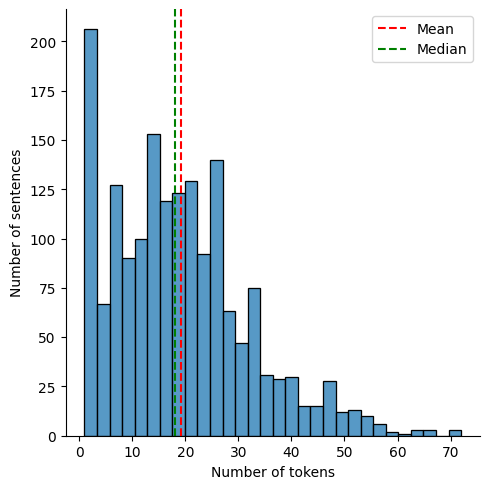

In [103]:
## Size of sentences

sents: list[dict] = [{
    "sentence": sentence,
    "num_of_tokens": len(nltk.word_tokenize(sentence))
} for sentence in train_df.sentence.tolist()]

largest_sent = reduce(lambda max, s: s if max.get("num_of_tokens") < s.get("num_of_tokens") else max, sents)
smallest_sent = reduce(lambda min, s: s if min.get("num_of_tokens") > s.get("num_of_tokens") else min, sents)

print("Sentence with largest number of tokens:")
print(largest_sent) # 82; “ Apple đã tập trung vào việc nâng cao đáng kể Chất lượng hình ảnh tuyệt đối và Độ chính xác màu sắc tuyệt đối của màn hình OLED bằng cách thực hiện hiệu chỉnh màn hình chính xác tại nhà máy , nâng hiệu suất hiển thị tổng thể của iPhone 12 Pro Max lên đến mức độ vượt trội , độ chính xác hoàn hảo đến mức không thể phân biệt bằng mắt thường ” , DisplayMate đánh giá .
print("Sentence with smallest number of tokens:")
print(smallest_sent) # Pin
print()

df = train_df.copy()
df["num_of_tokens"] = [s.get("num_of_tokens") for s in sents]

print(f"(Test query) {len(df.query('num_of_tokens >= 8 & num_of_tokens <= 10'))}")
print(df.describe())

## Render histogram
sbn.displot(data=df, x="num_of_tokens", bins=30, kind="hist")

plt.xlabel("Number of tokens")
plt.ylabel("Number of sentences")
plt.axvline(x=np.mean(df.num_of_tokens), color='red', linestyle='--', label='Mean')
plt.axvline(x=np.median(df.num_of_tokens), color='green', linestyle='--', label='Median')
plt.legend()

plt.show()

#### a. "Sentences" start with numbers
Conclusion: Most of "sentences" start with numbers (section number, quantity) contain only section numbers or along with titles. They don't contain any quintuple.

⇒ Remove all.

In [125]:
# train_df = pd.DataFrame(DatasetUtils.to_multi_quintuples_dict_list(training_dataset))

print(f"Size of dataset before modified: {len(train_df)}")

# Remove "sentences" start with numbers (\d*[(\\.[\d]*)]+)
train_df.drop(train_df[train_df.sentence.str.contains("^\d*[(\\.\d*)]+\W{1,}")].index.tolist(), inplace=True) # 105

print(f"Size of dataset after modified: {len(train_df)}")

Size of dataset before modified: 1732
Size of dataset after modified: 1670


#### b. Check if any sentence is duplicated

**Conclusion 1**: All duplicate sentences need to be removed.

Suggested command: ``train_df.loc[train_df.sentence.drop_duplicates().index.tolist()]``

(should do this after all other steps)

In [126]:
""" Check if any sentence is duplicated """

# train_df = pd.DataFrame(DatasetUtils.to_multi_quintuples_dict_list(training_dataset))
print(f"Size of the dataset before modified: {len(train_df)}")

dups = train_df[train_df.sentence.duplicated()]
print(f"Number of duplicates: {len(dups)}")

dups_with_quin = dups[dups.quintuples.notna()]
print(f"Duplicates where at least 1 quintuple exists: {len(dups_with_quin)} sentences in total.")

# for i in range(len(dups_with_quin)):
#   print(f"Tuple {i + 1}:")
#   print(train_df[train_df.sentence.str.contains(dups_with_quin.iloc[i].sentence)])

train_df = train_df.loc[train_df.sentence.drop_duplicates().index.tolist()] # remove duplicates
print(f"Size of dataset after modified: {len(train_df)}")

Size of the dataset before modified: 1670
Number of duplicates: 162
Duplicates where at least 1 quintuple exists: 0 sentences in total.
Size of dataset after modified: 1508


#### c. Special sentences
- Stats: (original/unique/quin_owner)
  - title: 44/44/0. "title : " is always at the first position of the sentences.
  - des: 499/216/24(23 unique)
  - alt: 500/332/1;
  - questions: 126/.../0. All sents containing "?" are questions.

- **Conclusion 2**: the sequences '(alt : )|(des : )|(title : )' does not contribute any meaning to a sentence, thus should be filtered out before processing.

- **Conclusion 3**:  
  - In questions and titles, there's no sentence that has at least 1 quintuple.
  - In "alt" sentences, there's only 1 sent that has quintuple (2).

  => Propose deleting:
    - All '?' & 'title' sentences: 170
    - 'alt' & 'des' sentences: only blank-sentence values (due to the existences of some ambiguous sentences)

- **Conclusion 4**: The sentences "starting with 'des : ', 'alt : ' & having at least 1 quin" need to be kept.

- **Conclusion 5**: after removing 'des : ', 'alt : ', the result sentences may have been existed in the original training dataset (there're ... duplicates in total)
=> Continue removing duplicates by the recommended command above.

In [137]:
# train_df[train_df.sentence.str.contains(r"alt")]#.query("quintuples.notna()")

In [138]:
"""
In this section (and maybe others), I define a "special sentence"
is a sentence containing "alt", "des", "title" or "?".
Purpose: Examine if a sentence containing "(alt : )|(des : )|(title : )|(\?)" can have quintuple or not.
Note that all duplicate sentences may be filtered out (or not) before examining.
"""

# train_df = pd.DataFrame(DatasetUtils.to_multi_quintuples_dict_list(training_dataset))

questions_and_titles = train_df[train_df.sentence.str.contains("(\?)|(title)")]
special_sentences = train_df[train_df.sentence.str.contains("(alt)|(des)")]
print()

## Questions & titles
# print(len(train_df[train_df.sentence.str.contains("title")]))
# print(len(train_df[train_df.sentence.str.contains("\?")]))
print(f"Sentences containing '?' and/or 'title : ' ({len(questions_and_titles)}) and having quintuple:", end=" ")
print(len(questions_and_titles[questions_and_titles.quintuples.notnull()]))
# print(special_sentences[special_sentences.sentence.str.contains("(title)", regex=True)])
print("=> Conclusion 3: The sentences containing '?' and/or 'title : ' should be removed.\n")

# Remove questions and titles
train_df.drop(questions_and_titles.index.tolist(), inplace=True)

## Special sentences
print(f"Number of special sentences starting with 'des : ', 'alt : ': {len(special_sentences)}")  # before removing: 1043; after: 592
# print(f"where number of dups: {len(special_sentences[special_sentences.sentence.duplicated()])}") # before removing: 451; after: 0

## Special sentences with quintuple
special_sentences_with_quin = special_sentences[special_sentences.quintuples.notna()]
print(f"Number of special sentences (starting with 'des : ', 'alt : ') having at least 1 quin: {len(special_sentences_with_quin)}")
print("=> Conclusion 4: Those sentences need to be kept.\n")
dups_bef = len(train_df[train_df.sentence.duplicated()])
print(f"Dups before removing 'des : ' & 'alt : ': {dups_bef}")

# Substitute "(des : )|(alt : )" with "" and replace old strings with those in train_df
for i in range(len(special_sentences)):
  new_sent = re.sub("(des : )|(alt : )", "", special_sentences.iloc[i].sentence)
  train_df.sentence.replace(special_sentences.iloc[i].sentence, new_sent, inplace=True)

  # if len(train_df[train_df.sentence == new_sent]) > 0:
  #   print(f"Tuple {i}:")
  #   print(f"Original:\n{special_sentences.iloc[i]}")
  #   print(f"Dup:\n{train_df[train_df.sentence == new_sent]}\n")

tmp = len(train_df[train_df.sentence.duplicated()])

print(f"Dups after removing 'des : ' & 'alt : ': {tmp}")
print(f"""
Conclusion 5: after removing 'des : ', 'alt : ', the result sentences may have
been existed in the original training dataset ({tmp - dups_bef} increased)"""
)

new_dups = train_df[train_df.sentence.duplicated()]
# for i in range(len(new_dups)):
#   print(f"Tuple {i}:")
#   print(train_df[train_df.sentence == new_dups.iloc[i].sentence], end="\n")

# uncomment the code above to print all tuples
print("""
After observing all the duplicates, we can conclude that in each duplicate tuple,
all members are completely the same.
So, we can delete them by reusing the recommended command (conclusion 1)."""
)

train_df = train_df.loc[train_df.sentence.drop_duplicates().index.tolist()] #

# print(f"\nDups after being removed for the 2nd time: {len(train_df[train_df.sentence.duplicated()])} (test)")
print(f"\nSize of dataset after modified: {len(train_df)}")


Sentences containing '?' and/or 'title : ' (61) and having quintuple: 0
=> Conclusion 3: The sentences containing '?' and/or 'title : ' should be removed.

Number of special sentences starting with 'des : ', 'alt : ': 253
Number of special sentences (starting with 'des : ', 'alt : ') having at least 1 quin: 0
=> Conclusion 4: Those sentences need to be kept.

Dups before removing 'des : ' & 'alt : ': 0
Dups after removing 'des : ' & 'alt : ': 93

Conclusion 5: after removing 'des : ', 'alt : ', the result sentences may have
been existed in the original training dataset (93 increased)

After observing all the duplicates, we can conclude that in each duplicate tuple,
all members are completely the same.
So, we can delete them by reusing the recommended command (conclusion 1).

Size of dataset after modified: 1354


<ipython-input-138-6cc8252bb561>:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  questions_and_titles = train_df[train_df.sentence.str.contains("(\?)|(title)")]
<ipython-input-138-6cc8252bb561>:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  special_sentences = train_df[train_df.sentence.str.contains("(alt)|(des)")]


#### d. Examine sizes of the training sentences

Note that you should run the previous block to remove redundant sentences/sequences.



- Sentences with ...
  - 0-3 tokens:
  - 4 tokens:
  - 5 tokens:
  - 6 tokens:

    ...

In [121]:
""" Examine sizes of the test sentences """
MINIMUM_NUM_OF_TOKENS = 3

# train_df = pd.DataFrame(DatasetUtils.to_multi_quintuples_dict_list(training_dataset))
print(f"Size of dataset before modified: {len(train_df)}\n")

for min_t in range(MINIMUM_NUM_OF_TOKENS + 1):

  short_sentences = train_df.loc[[item[0] for item in train_df.sentence.items() if len(nltk.word_tokenize(item[1])) <= min_t]]
  short_sentence_indexes_with_quin = [i for i, row in short_sentences.iterrows() if not row.quintuples is None]

  print(f"Given minimum number of tokens is {min_t}.")
  print(f"Number of short sentences: {len(short_sentences)}")
  print(f"Number of short sentences with quin: {len(short_sentence_indexes_with_quin)}")
  print(f"=> Delete: {len(short_sentences) - len(short_sentence_indexes_with_quin)}")

  ## demo the process of removing short sentences
  short_sentences.drop(short_sentence_indexes_with_quin, inplace=True)
  # print(f"Number of short sentences (after modified): {len(short_sentences)}") # validate
  train_df.drop(short_sentences.index.tolist(), inplace=True)
  # print(f"test size: {len(train_df)}") # validate
  print()

# for i, row in short_sentences.iterrows():
#   if not row.quintuples is None:
#     print(row)

print(f"Size of dataset after modified: {len(train_df)}\n")

Size of training set before modified: 1354

Given minimum number of tokens is 0.
Number of short sentences: 0
Number of short sentences with quin: 0
=> Delete: 0

Given minimum number of tokens is 1.
Number of short sentences: 5
Number of short sentences with quin: 0
=> Delete: 5

Given minimum number of tokens is 2.
Number of short sentences: 22
Number of short sentences with quin: 0
=> Delete: 22

Given minimum number of tokens is 3.
Number of short sentences: 21
Number of short sentences with quin: 0
=> Delete: 21

Given minimum number of tokens is 4.
Number of short sentences: 27
Number of short sentences with quin: 0
=> Delete: 27

Given minimum number of tokens is 5.
Number of short sentences: 27
Number of short sentences with quin: 0
=> Delete: 27

Given minimum number of tokens is 6.
Number of short sentences: 36
Number of short sentences with quin: 0
=> Delete: 36

Given minimum number of tokens is 7.
Number of short sentences: 32
Number of short sentences with quin: 0
=> Dele

#### e. Others


In [140]:
# Find data points from 2 sentences:
# Total: 51 (after cleaning section titles & other sentences starting with number); having quin: 25 (unique: 17)

# remove sentences start with number
df = train_df.copy()
# df = flattened_train_df

# print(len(flattened_train_df.sentence.unique()))
query = [i for i, s in df.sentence.items() if regex.match(r"", s)]
twos = df[df.sentence.str.contains("[\\.]( \\.){0,} .*$")]#.query("label.isna()")
twos
# ending_dots = df[df.sentence.str.contains(r" \.$")]#.query("label.isna()")
# ending_dots
# old = df[df.sentence.str.contains(".{1,} [\\.] .{1,}")]
# old.drop(twos.index.tolist())
df[df.sentence.str.contains(":")]

<ipython-input-140-b3ff31becc35>:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  twos = df[df.sentence.str.contains("[\\.]( \\.){0,} .*$")]#.query("label.isna()")


,sentence,quintuples
18,des :,None
161,Galaxy A33 sở hữu 4 phiên bản màu sắc đa dạng ...,None
223,Hiệu năng ổn định đến từ con chip Exynos 1280 ...,None
251,"Bạn có 4 lựa chọn màu sắc bao gồm : đen , trắn...",None
255,"Tương tự , Samsung Galaxy A32 cũng có 4 lựa ch...",None
272,Khi mua điện thoại Samsung Galaxy A33 5G và Ga...,None
325,"Theo trải nghiệm nhanh , sau 30 phút chơi Call...",None
344,Đầu tiên cần khẳng định : Đây là một chiếc điệ...,None
348,Title : So sánh Xiaomi Mi 11 và iPhone 12 : Cu...,None
365,src : https : / / cdn.tgdd.vn / Files / 2021 /...,None


#### General stats (after modified)

##### Distribution of sentence size

Sentence size is calculated by number of tokens.

Sentence with largest number of tokens:
{'sentence': 'Hứa hẹn lớn của Xiaomi 13 Pro chắc chắn là về máy ảnh : bạn có cảm biến máy ảnh chính loại 1 inch , lớn hơn những gì bạn có trên Galaxy và về mặt lý thuyết sẽ hoạt động tốt hơn vào ban đêm và bạn có khả năng thu phóng 3,2 lần máy ảnh có một số siêu năng lực mà chúng ta sẽ nói đến dưới đây .', 'num_of_tokens': 72}
Sentence with smallest number of tokens:
{'sentence': 'iPhone 11 là hiệu năng tốt hơn .', 'num_of_tokens': 8}

(Test query) Empty DataFrame
Columns: [sentence, quintuples, num_of_tokens]
Index: []
       num_of_tokens
count    1184.000000
mean       24.557432
std        11.529304
min         8.000000
25%        16.000000
50%        23.000000
75%        31.000000
max        72.000000


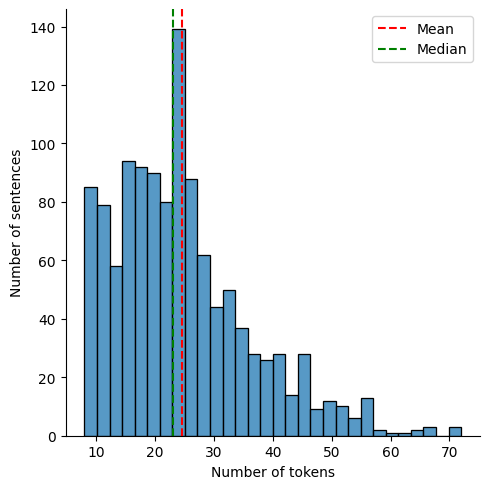

In [123]:
## Size of sentences

sents: list[dict] = [{
    "sentence": sentence,
    "num_of_tokens": len(nltk.word_tokenize(sentence))
} for sentence in train_df.sentence.tolist()]

largest_sent = reduce(lambda max, s: s if max.get("num_of_tokens") < s.get("num_of_tokens") else max, sents)
smallest_sent = reduce(lambda min, s: s if min.get("num_of_tokens") > s.get("num_of_tokens") else min, sents)

print("Sentence with largest number of tokens:")
print(largest_sent) # 72
print("Sentence with smallest number of tokens:")
print(smallest_sent) # 8
print()

df = train_df.copy()
df["num_of_tokens"] = [s.get("num_of_tokens") for s in sents]

print(f"(Test query) {(df.query('num_of_tokens >= 4 & num_of_tokens <= 6'))}")
print(df.describe())

sbn.displot(data=df, x="num_of_tokens", bins=30, kind="hist")

plt.xlabel("Number of tokens")
plt.ylabel("Number of sentences")
plt.axvline(x=np.mean(df.num_of_tokens), color='red', linestyle='--', label='Mean')
plt.axvline(x=np.median(df.num_of_tokens), color='green', linestyle='--', label='Median')
plt.legend()

plt.show()

## Problems

Problems with data? Which needs to be cleaned? Solutions?
- Imbalance (having at least 1 vs no quintuple; 'label' biases "COM+" value)
  
  -> removing, sampling & augmentation ... ?

- Difference in definition of "word" & "token" in Vietnamese vs English; most of product names is English while remaining is Vietnamese.
  - how to handle Vietnamese compound noun? segmentation. -> which lib or technique? consistency between sentence & quintuple (especially product name, ...)?
  - stopwords? which ones should be removed? (considered in VNese)
- Lack of data (or unimportant data...), especially in lines containing "des:", "title:"...

  ->

- Duplicate: some sentences are quite similar; they even are substring of others.

  ->

